## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(np.array(self.df.iloc[index]))
        label = torch.tensor(np.array([self.price.iloc[index]]))
        return {"sample": sample, "label": label}
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=0)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [43]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*1)
        self.layer5 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        return self.layer5(x)

## Training Function

In [7]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"].float()
            label = data["label"].float()
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.999510  time: 4.144
---[ITER 20] loss: 0.984251  time: 5.766
---[ITER 30] loss: 0.946978  time: 4.527
---[ITER 40] loss: 0.932803  time: 2.779
---[ITER 50] loss: 0.954539  time: 3.035
---[ITER 60] loss: 0.916127  time: 3.103
---[ITER 70] loss: 0.913140  time: 2.755
---[ITER 80] loss: 0.845910  time: 2.777
---[ITER 90] loss: 0.823710  time: 2.817
---[ITER 100] loss: 0.793165  time: 3.687
---[ITER 110] loss: 0.732996  time: 4.820
---[ITER 120] loss: 0.693747  time: 4.791
---[ITER 130] loss: 0.638694  time: 4.957
---[ITER 140] loss: 0.630213  time: 3.527
---[ITER 150] loss: 0.588532  time: 3.330
---[ITER 160] loss: 0.590650  time: 3.846
[EPOCH 1] loss: 0.799680  time: 63.607
---[ITER 10] loss: 0.584250  time: 3.076
---[ITER 20] loss: 0.542548  time: 3.554
---[ITER 30] loss: 0.575074  time: 3.235
---[ITER 40] loss: 0.575644  time: 2.936
---[ITER 50] loss: 0.560803  time: 3.554
---[ITER 60] loss: 0.549040  time: 2.881
---[ITER 70] loss: 0.544839  ti

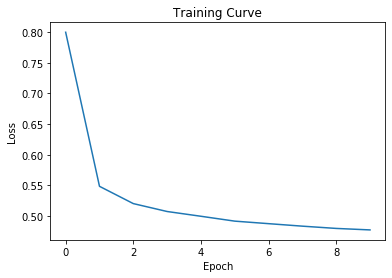

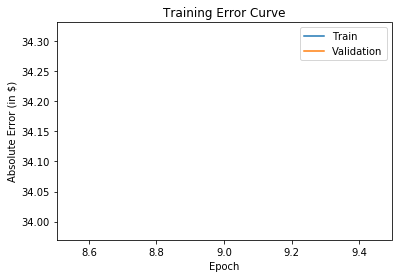

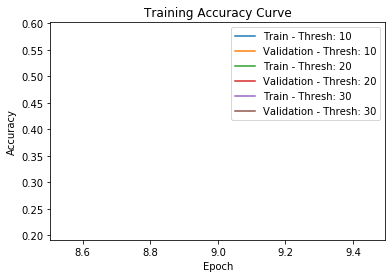

---[ITER 10] loss: 0.471930  time: 3.293
---[ITER 20] loss: 0.478343  time: 3.281
---[ITER 30] loss: 0.490855  time: 3.372
---[ITER 40] loss: 0.477691  time: 3.475
---[ITER 50] loss: 0.483863  time: 3.799
---[ITER 60] loss: 0.459857  time: 3.865
---[ITER 70] loss: 0.469944  time: 3.797
---[ITER 80] loss: 0.491555  time: 3.857
---[ITER 90] loss: 0.473681  time: 4.116
---[ITER 100] loss: 0.485525  time: 4.058
---[ITER 110] loss: 0.467914  time: 3.669
---[ITER 120] loss: 0.460998  time: 4.994
---[ITER 130] loss: 0.462074  time: 4.347
---[ITER 140] loss: 0.467695  time: 4.601
---[ITER 150] loss: 0.469732  time: 4.541
---[ITER 160] loss: 0.465565  time: 3.945
[EPOCH 11] loss: 0.473506  time: 66.676
---[ITER 10] loss: 0.471876  time: 3.582
---[ITER 20] loss: 0.470260  time: 3.923
---[ITER 30] loss: 0.468827  time: 4.843
---[ITER 40] loss: 0.470493  time: 3.527
---[ITER 50] loss: 0.480144  time: 7.684
---[ITER 60] loss: 0.480100  time: 5.476
---[ITER 70] loss: 0.465126  time: 4.653
---[ITER 8

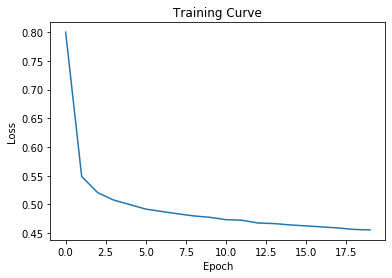

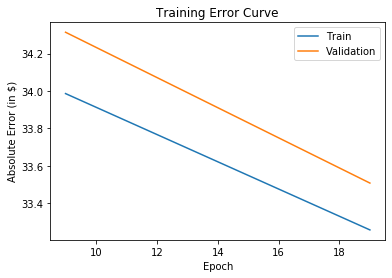

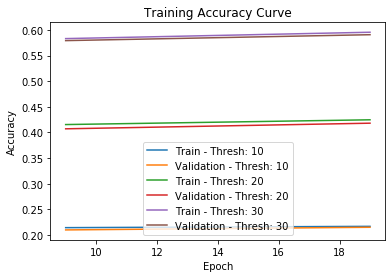

---[ITER 10] loss: 0.457098  time: 4.814
---[ITER 20] loss: 0.445020  time: 5.259
---[ITER 30] loss: 0.461565  time: 4.661
---[ITER 40] loss: 0.448051  time: 3.248
---[ITER 50] loss: 0.430548  time: 3.372
---[ITER 60] loss: 0.451944  time: 3.247
---[ITER 70] loss: 0.454424  time: 3.781
---[ITER 80] loss: 0.473228  time: 3.188
---[ITER 90] loss: 0.446835  time: 4.446
---[ITER 100] loss: 0.458072  time: 3.869
---[ITER 110] loss: 0.459652  time: 4.764
---[ITER 120] loss: 0.457721  time: 8.537
---[ITER 130] loss: 0.443505  time: 3.718
---[ITER 140] loss: 0.459960  time: 4.874
---[ITER 150] loss: 0.455475  time: 3.684
---[ITER 160] loss: 0.446394  time: 3.910
[EPOCH 21] loss: 0.453170  time: 72.068
---[ITER 10] loss: 0.450593  time: 4.762
---[ITER 20] loss: 0.457942  time: 4.547
---[ITER 30] loss: 0.457873  time: 5.146
---[ITER 40] loss: 0.457475  time: 3.373
---[ITER 50] loss: 0.438851  time: 4.619
---[ITER 60] loss: 0.455626  time: 4.450
---[ITER 70] loss: 0.446972  time: 6.243
---[ITER 8

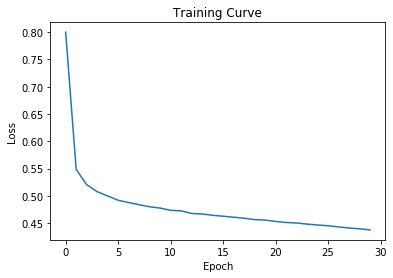

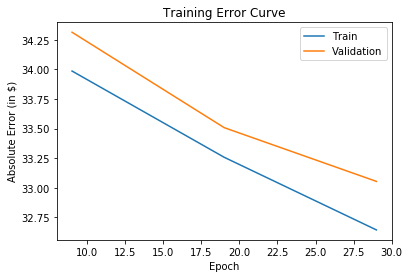

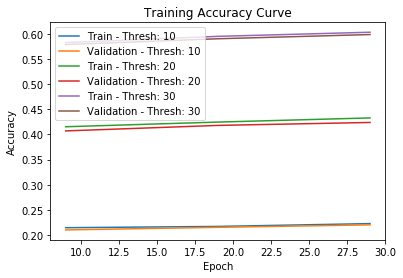

---[ITER 10] loss: 0.432719  time: 3.165
---[ITER 20] loss: 0.448126  time: 3.042
---[ITER 30] loss: 0.422665  time: 3.069
---[ITER 40] loss: 0.433013  time: 4.313
---[ITER 50] loss: 0.432958  time: 3.463
---[ITER 60] loss: 0.438769  time: 3.447
---[ITER 70] loss: 0.435770  time: 3.406
---[ITER 80] loss: 0.441803  time: 3.197
---[ITER 90] loss: 0.443879  time: 3.243
---[ITER 100] loss: 0.422429  time: 3.618
---[ITER 110] loss: 0.435686  time: 4.909
---[ITER 120] loss: 0.438608  time: 5.085
---[ITER 130] loss: 0.458074  time: 5.174
---[ITER 140] loss: 0.423180  time: 4.697
---[ITER 150] loss: 0.438447  time: 3.244
---[ITER 160] loss: 0.441798  time: 4.338
[EPOCH 31] loss: 0.436868  time: 64.334
---[ITER 10] loss: 0.434042  time: 5.283
---[ITER 20] loss: 0.420114  time: 6.811
---[ITER 30] loss: 0.435931  time: 4.521
---[ITER 40] loss: 0.434145  time: 6.406
---[ITER 50] loss: 0.451728  time: 4.892
---[ITER 60] loss: 0.421705  time: 4.915
---[ITER 70] loss: 0.421863  time: 4.913
---[ITER 8

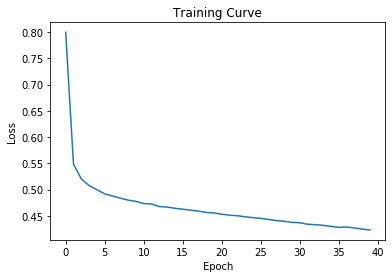

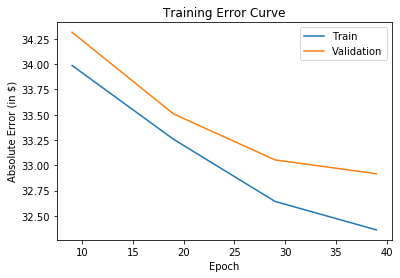

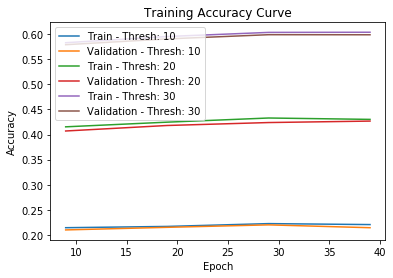

---[ITER 10] loss: 0.435294  time: 3.148
---[ITER 20] loss: 0.414328  time: 3.160
---[ITER 30] loss: 0.428380  time: 3.168
---[ITER 40] loss: 0.396766  time: 3.254
---[ITER 50] loss: 0.419883  time: 3.184
---[ITER 60] loss: 0.421320  time: 3.165
---[ITER 70] loss: 0.415502  time: 3.220
---[ITER 80] loss: 0.420112  time: 3.265
---[ITER 90] loss: 0.422515  time: 3.204
---[ITER 100] loss: 0.414681  time: 3.243
---[ITER 110] loss: 0.431536  time: 3.159
---[ITER 120] loss: 0.410428  time: 3.085
---[ITER 130] loss: 0.431146  time: 3.020
---[ITER 140] loss: 0.435411  time: 3.027
---[ITER 150] loss: 0.426017  time: 2.945
---[ITER 160] loss: 0.427293  time: 3.130
[EPOCH 41] loss: 0.422250  time: 52.969
---[ITER 10] loss: 0.416734  time: 3.218
---[ITER 20] loss: 0.407840  time: 3.464
---[ITER 30] loss: 0.420823  time: 3.172
---[ITER 40] loss: 0.410779  time: 3.226
---[ITER 50] loss: 0.437672  time: 3.205
---[ITER 60] loss: 0.409765  time: 3.531
---[ITER 70] loss: 0.429899  time: 3.185
---[ITER 8

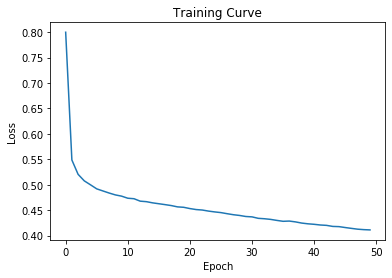

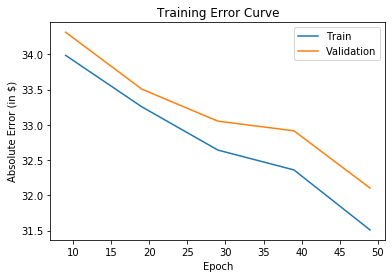

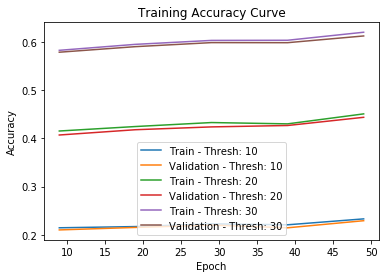

---[ITER 10] loss: 0.402370  time: 5.253
---[ITER 20] loss: 0.408219  time: 5.014
---[ITER 30] loss: 0.396290  time: 5.081
---[ITER 40] loss: 0.425795  time: 4.810
---[ITER 50] loss: 0.411628  time: 4.805
---[ITER 60] loss: 0.408506  time: 4.704
---[ITER 70] loss: 0.414996  time: 5.187
---[ITER 80] loss: 0.412035  time: 4.804
---[ITER 90] loss: 0.421504  time: 4.617
---[ITER 100] loss: 0.415021  time: 4.841
---[ITER 110] loss: 0.410046  time: 4.812
---[ITER 120] loss: 0.408529  time: 4.905
---[ITER 130] loss: 0.399174  time: 4.648
---[ITER 140] loss: 0.416212  time: 4.699
---[ITER 150] loss: 0.418712  time: 5.020
---[ITER 160] loss: 0.398784  time: 5.914
[EPOCH 51] loss: 0.410402  time: 83.662
---[ITER 10] loss: 0.413738  time: 5.391
---[ITER 20] loss: 0.401172  time: 5.891
---[ITER 30] loss: 0.404341  time: 5.145
---[ITER 40] loss: 0.397638  time: 5.364
---[ITER 50] loss: 0.420867  time: 6.785
---[ITER 60] loss: 0.412569  time: 6.441
---[ITER 70] loss: 0.426565  time: 7.102
---[ITER 8

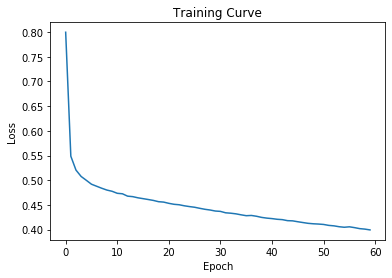

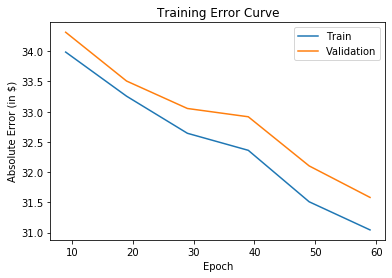

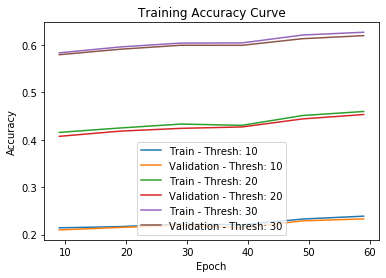

---[ITER 10] loss: 0.387389  time: 5.362
---[ITER 20] loss: 0.398139  time: 5.253
---[ITER 30] loss: 0.391130  time: 5.147
---[ITER 40] loss: 0.395446  time: 5.087
---[ITER 50] loss: 0.397727  time: 5.623
---[ITER 60] loss: 0.387738  time: 6.332
---[ITER 70] loss: 0.398716  time: 5.691
---[ITER 80] loss: 0.392131  time: 5.225
---[ITER 90] loss: 0.404167  time: 6.156
---[ITER 100] loss: 0.406756  time: 5.438
---[ITER 110] loss: 0.411982  time: 5.984
---[ITER 120] loss: 0.402916  time: 5.592
---[ITER 130] loss: 0.401704  time: 5.865
---[ITER 140] loss: 0.403765  time: 6.921
---[ITER 150] loss: 0.397170  time: 6.140
---[ITER 160] loss: 0.401225  time: 5.353
[EPOCH 61] loss: 0.398728  time: 95.469
---[ITER 10] loss: 0.394057  time: 4.900
---[ITER 20] loss: 0.385075  time: 4.898
---[ITER 30] loss: 0.407112  time: 4.994
---[ITER 40] loss: 0.394625  time: 4.972
---[ITER 50] loss: 0.388589  time: 4.496
---[ITER 60] loss: 0.391861  time: 4.614
---[ITER 70] loss: 0.402131  time: 5.105
---[ITER 8

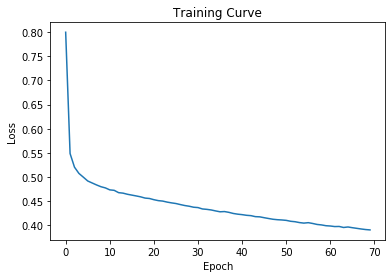

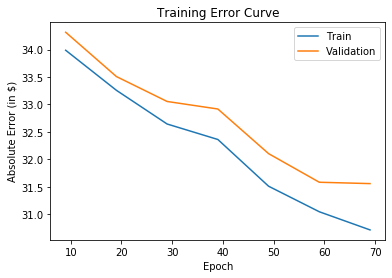

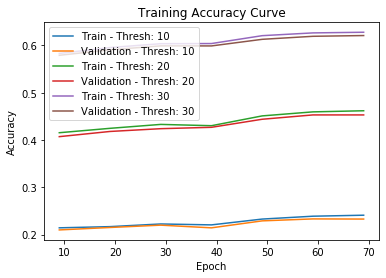

---[ITER 10] loss: 0.375993  time: 5.136
---[ITER 20] loss: 0.376701  time: 5.427
---[ITER 30] loss: 0.399267  time: 4.983
---[ITER 40] loss: 0.376038  time: 4.973
---[ITER 50] loss: 0.376113  time: 5.227
---[ITER 60] loss: 0.394609  time: 5.713
---[ITER 70] loss: 0.407009  time: 5.341
---[ITER 80] loss: 0.391959  time: 6.027
---[ITER 90] loss: 0.395317  time: 5.142
---[ITER 100] loss: 0.387689  time: 5.711
---[ITER 110] loss: 0.393464  time: 5.383
---[ITER 120] loss: 0.397155  time: 5.415
---[ITER 130] loss: 0.404324  time: 5.580
---[ITER 140] loss: 0.397885  time: 5.428
---[ITER 150] loss: 0.393683  time: 5.341
---[ITER 160] loss: 0.380224  time: 5.424
[EPOCH 71] loss: 0.390284  time: 90.750
---[ITER 10] loss: 0.380261  time: 6.348
---[ITER 20] loss: 0.381654  time: 6.031
---[ITER 30] loss: 0.396158  time: 5.425
---[ITER 40] loss: 0.381370  time: 5.375
---[ITER 50] loss: 0.390291  time: 5.007
---[ITER 60] loss: 0.403541  time: 4.863
---[ITER 70] loss: 0.379651  time: 5.199
---[ITER 8

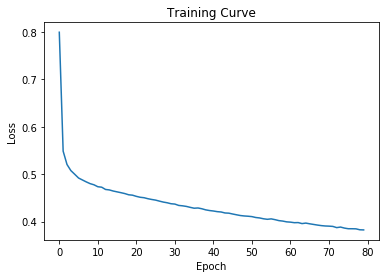

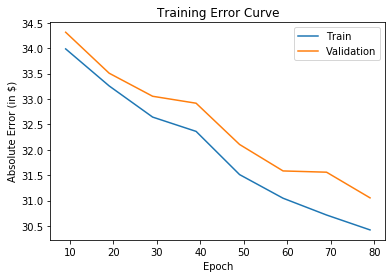

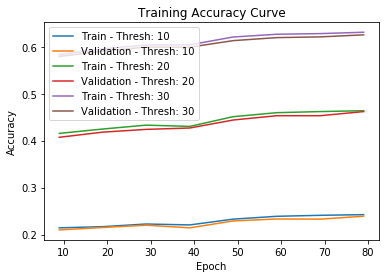

---[ITER 10] loss: 0.374862  time: 3.750
---[ITER 20] loss: 0.367882  time: 3.638
---[ITER 30] loss: 0.394952  time: 3.450
---[ITER 40] loss: 0.370774  time: 3.414
---[ITER 50] loss: 0.385814  time: 3.377
---[ITER 60] loss: 0.382522  time: 3.286
---[ITER 70] loss: 0.387451  time: 3.385
---[ITER 80] loss: 0.383652  time: 3.362
---[ITER 90] loss: 0.379606  time: 3.422
---[ITER 100] loss: 0.391209  time: 3.353
---[ITER 110] loss: 0.379178  time: 3.269
---[ITER 120] loss: 0.371907  time: 3.409
---[ITER 130] loss: 0.379256  time: 3.613
---[ITER 140] loss: 0.377982  time: 3.415
---[ITER 150] loss: 0.387291  time: 3.466
---[ITER 160] loss: 0.374386  time: 3.564
[EPOCH 81] loss: 0.380302  time: 57.864
---[ITER 10] loss: 0.382042  time: 3.402
---[ITER 20] loss: 0.389720  time: 3.861
---[ITER 30] loss: 0.362637  time: 3.731
---[ITER 40] loss: 0.390569  time: 3.417
---[ITER 50] loss: 0.379391  time: 3.398
---[ITER 60] loss: 0.369462  time: 3.363
---[ITER 70] loss: 0.376818  time: 3.247
---[ITER 8

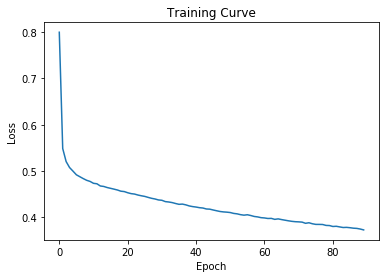

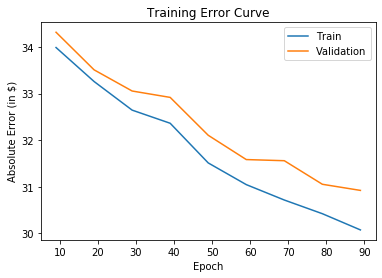

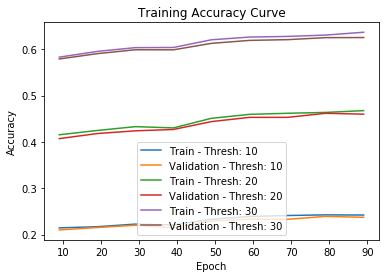

---[ITER 10] loss: 0.376288  time: 5.049
---[ITER 20] loss: 0.368414  time: 4.397
---[ITER 30] loss: 0.363146  time: 4.301
---[ITER 40] loss: 0.382005  time: 3.323
---[ITER 50] loss: 0.386047  time: 3.895
---[ITER 60] loss: 0.369111  time: 3.471
---[ITER 70] loss: 0.373507  time: 3.395
---[ITER 80] loss: 0.369740  time: 3.529
---[ITER 90] loss: 0.368167  time: 3.879
---[ITER 100] loss: 0.372296  time: 4.262
---[ITER 110] loss: 0.372698  time: 4.310
---[ITER 120] loss: 0.360374  time: 4.444
---[ITER 130] loss: 0.365721  time: 3.574
---[ITER 140] loss: 0.381125  time: 3.882
---[ITER 150] loss: 0.368309  time: 3.555
---[ITER 160] loss: 0.380967  time: 3.626
[EPOCH 91] loss: 0.373143  time: 65.186
---[ITER 10] loss: 0.354428  time: 3.197
---[ITER 20] loss: 0.374841  time: 3.609
---[ITER 30] loss: 0.391707  time: 3.924
---[ITER 40] loss: 0.372589  time: 3.719
---[ITER 50] loss: 0.369317  time: 3.753
---[ITER 60] loss: 0.359454  time: 4.158
---[ITER 70] loss: 0.377098  time: 5.854
---[ITER 8

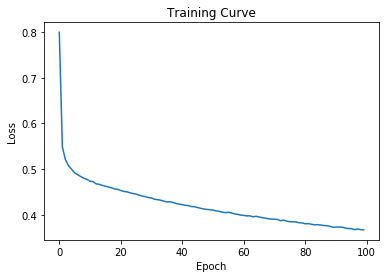

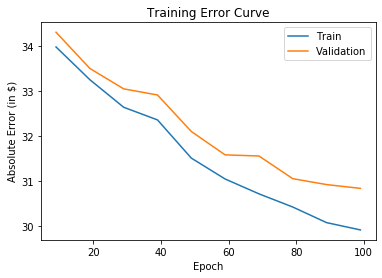

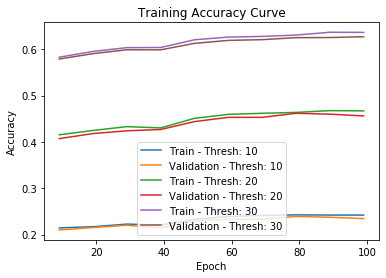

---[ITER 10] loss: 0.363639  time: 3.111
---[ITER 20] loss: 0.375568  time: 3.428
---[ITER 30] loss: 0.381138  time: 3.034
---[ITER 40] loss: 0.357702  time: 3.061
---[ITER 50] loss: 0.374223  time: 3.008
---[ITER 60] loss: 0.371297  time: 3.254
---[ITER 70] loss: 0.364015  time: 4.004
---[ITER 80] loss: 0.357128  time: 3.910
---[ITER 90] loss: 0.360137  time: 4.095
---[ITER 100] loss: 0.353605  time: 4.061
---[ITER 110] loss: 0.364532  time: 3.564
---[ITER 120] loss: 0.373044  time: 3.317
---[ITER 130] loss: 0.366505  time: 3.788
---[ITER 140] loss: 0.366019  time: 3.727
---[ITER 150] loss: 0.365449  time: 3.869
---[ITER 160] loss: 0.370157  time: 4.190
[EPOCH 101] loss: 0.366846  time: 60.146
---[ITER 10] loss: 0.352881  time: 4.334
---[ITER 20] loss: 0.374420  time: 3.613
---[ITER 30] loss: 0.370659  time: 3.157
---[ITER 40] loss: 0.373761  time: 4.004
---[ITER 50] loss: 0.372985  time: 3.294
---[ITER 60] loss: 0.360970  time: 4.137
---[ITER 70] loss: 0.376100  time: 3.536
---[ITER 

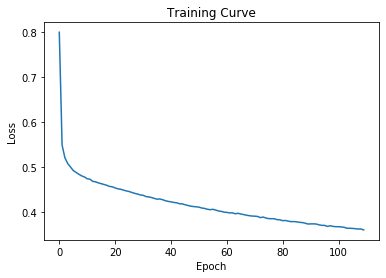

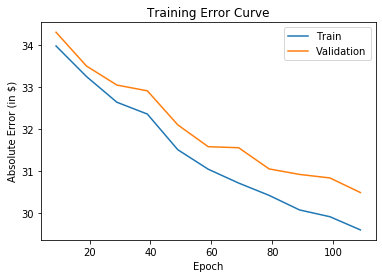

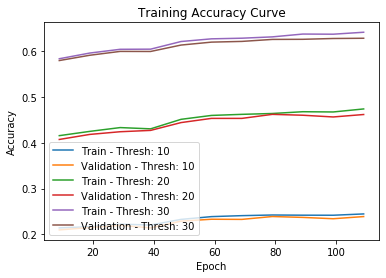

---[ITER 10] loss: 0.356305  time: 3.272
---[ITER 20] loss: 0.370787  time: 2.894
---[ITER 30] loss: 0.361821  time: 3.068
---[ITER 40] loss: 0.352362  time: 3.045
---[ITER 50] loss: 0.353833  time: 3.762
---[ITER 60] loss: 0.360672  time: 3.646
---[ITER 70] loss: 0.362207  time: 3.552
---[ITER 80] loss: 0.363370  time: 3.157
---[ITER 90] loss: 0.363268  time: 3.188
---[ITER 100] loss: 0.371847  time: 3.001
---[ITER 110] loss: 0.366020  time: 2.983
---[ITER 120] loss: 0.354811  time: 2.940
---[ITER 130] loss: 0.347121  time: 2.917
---[ITER 140] loss: 0.351990  time: 2.891
---[ITER 150] loss: 0.349768  time: 2.966
---[ITER 160] loss: 0.358372  time: 3.127
[EPOCH 111] loss: 0.358796  time: 52.722
---[ITER 10] loss: 0.358918  time: 3.066
---[ITER 20] loss: 0.356369  time: 3.363
---[ITER 30] loss: 0.353883  time: 3.068
---[ITER 40] loss: 0.360306  time: 3.063
---[ITER 50] loss: 0.359512  time: 3.146
---[ITER 60] loss: 0.362897  time: 3.126
---[ITER 70] loss: 0.361230  time: 3.089
---[ITER 

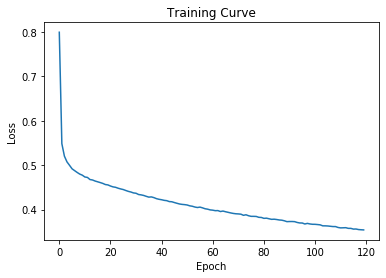

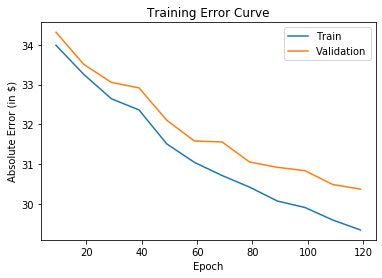

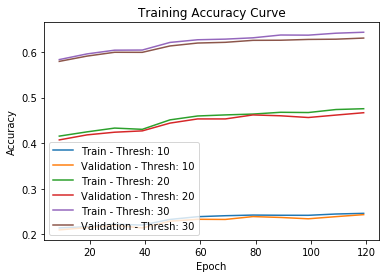

---[ITER 10] loss: 0.351527  time: 3.038
---[ITER 20] loss: 0.368963  time: 3.189
---[ITER 30] loss: 0.353317  time: 3.067
---[ITER 40] loss: 0.350359  time: 3.119
---[ITER 50] loss: 0.357682  time: 3.068
---[ITER 60] loss: 0.361932  time: 2.994
---[ITER 70] loss: 0.351645  time: 2.930
---[ITER 80] loss: 0.357081  time: 2.960
---[ITER 90] loss: 0.348945  time: 3.169
---[ITER 100] loss: 0.353063  time: 2.878
---[ITER 110] loss: 0.350566  time: 3.142
---[ITER 120] loss: 0.355549  time: 2.916
---[ITER 130] loss: 0.347390  time: 2.950
---[ITER 140] loss: 0.349922  time: 3.018
---[ITER 150] loss: 0.351908  time: 2.983
---[ITER 160] loss: 0.347210  time: 3.237
[EPOCH 121] loss: 0.353130  time: 51.026
---[ITER 10] loss: 0.373712  time: 2.944
---[ITER 20] loss: 0.356027  time: 2.910
---[ITER 30] loss: 0.346605  time: 2.960
---[ITER 40] loss: 0.337951  time: 2.990
---[ITER 50] loss: 0.362330  time: 3.270
---[ITER 60] loss: 0.349081  time: 3.227
---[ITER 70] loss: 0.358417  time: 3.527
---[ITER 

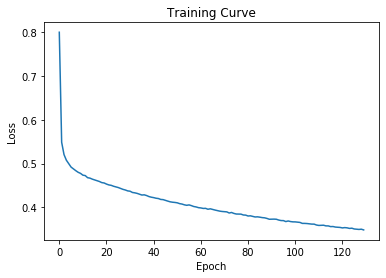

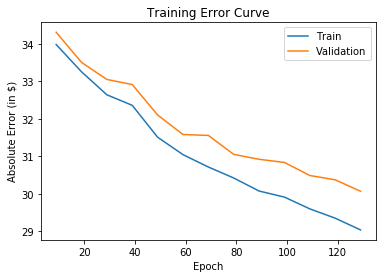

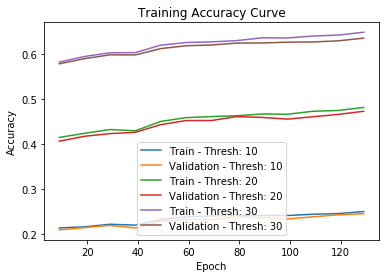

---[ITER 10] loss: 0.349660  time: 4.231
---[ITER 20] loss: 0.346922  time: 3.721
---[ITER 30] loss: 0.346658  time: 3.987
---[ITER 40] loss: 0.343724  time: 3.220
---[ITER 50] loss: 0.355576  time: 3.289
---[ITER 60] loss: 0.347895  time: 3.047
---[ITER 70] loss: 0.333705  time: 3.010
---[ITER 80] loss: 0.354603  time: 3.285
---[ITER 90] loss: 0.341395  time: 3.139
---[ITER 100] loss: 0.346344  time: 3.089
---[ITER 110] loss: 0.355335  time: 3.176
---[ITER 120] loss: 0.343352  time: 3.137
---[ITER 130] loss: 0.351869  time: 2.995
---[ITER 140] loss: 0.346502  time: 3.030
---[ITER 150] loss: 0.336525  time: 2.991
---[ITER 160] loss: 0.368274  time: 3.071
[EPOCH 131] loss: 0.348175  time: 54.717
---[ITER 10] loss: 0.349296  time: 2.960
---[ITER 20] loss: 0.341881  time: 2.980
---[ITER 30] loss: 0.351189  time: 2.974
---[ITER 40] loss: 0.348804  time: 3.000
---[ITER 50] loss: 0.335848  time: 3.070
---[ITER 60] loss: 0.343204  time: 3.422
---[ITER 70] loss: 0.350426  time: 3.099
---[ITER 

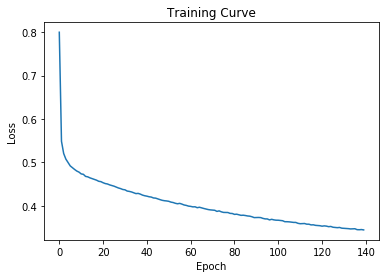

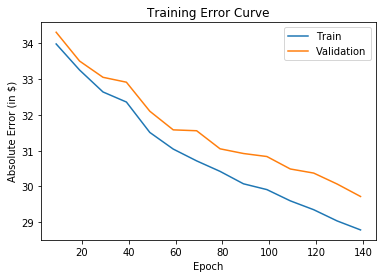

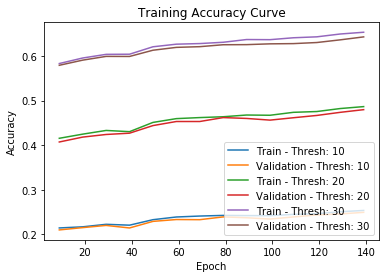

---[ITER 10] loss: 0.340103  time: 3.224
---[ITER 20] loss: 0.338688  time: 3.010
---[ITER 30] loss: 0.348398  time: 3.345
---[ITER 40] loss: 0.350237  time: 2.977
---[ITER 50] loss: 0.335122  time: 2.911
---[ITER 60] loss: 0.350688  time: 3.190
---[ITER 70] loss: 0.357236  time: 3.058
---[ITER 80] loss: 0.346171  time: 3.099
---[ITER 90] loss: 0.337617  time: 3.132
---[ITER 100] loss: 0.333584  time: 3.307
---[ITER 110] loss: 0.344808  time: 3.290
---[ITER 120] loss: 0.353304  time: 3.623
---[ITER 130] loss: 0.348109  time: 3.547
---[ITER 140] loss: 0.364629  time: 3.094
---[ITER 150] loss: 0.342841  time: 3.026
---[ITER 160] loss: 0.341413  time: 3.056
[EPOCH 141] loss: 0.345186  time: 53.200
---[ITER 10] loss: 0.329950  time: 2.920
---[ITER 20] loss: 0.337984  time: 2.988
---[ITER 30] loss: 0.354660  time: 3.139
---[ITER 40] loss: 0.336202  time: 3.124
---[ITER 50] loss: 0.347025  time: 4.145
---[ITER 60] loss: 0.337370  time: 3.227
---[ITER 70] loss: 0.338283  time: 3.553
---[ITER 

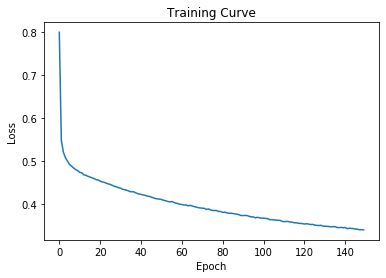

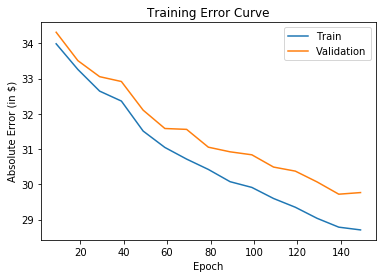

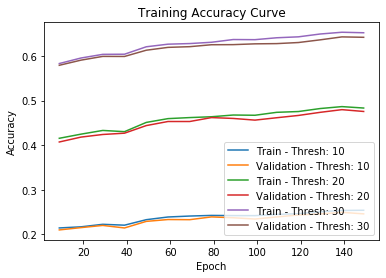

---[ITER 10] loss: 0.340956  time: 2.955
---[ITER 20] loss: 0.337870  time: 2.559
---[ITER 30] loss: 0.339096  time: 2.558
---[ITER 40] loss: 0.342914  time: 2.513
---[ITER 50] loss: 0.340778  time: 2.616
---[ITER 60] loss: 0.329173  time: 2.570
---[ITER 70] loss: 0.339964  time: 2.529
---[ITER 80] loss: 0.336333  time: 2.590
---[ITER 90] loss: 0.330284  time: 3.154
---[ITER 100] loss: 0.354632  time: 2.539
---[ITER 110] loss: 0.340164  time: 2.486
---[ITER 120] loss: 0.346608  time: 2.492
---[ITER 130] loss: 0.338197  time: 2.500
---[ITER 140] loss: 0.348431  time: 2.581
---[ITER 150] loss: 0.340099  time: 2.532
---[ITER 160] loss: 0.325981  time: 2.617
[EPOCH 151] loss: 0.339080  time: 43.766
---[ITER 10] loss: 0.336369  time: 2.528
---[ITER 20] loss: 0.339275  time: 2.516
---[ITER 30] loss: 0.356887  time: 2.501
---[ITER 40] loss: 0.348647  time: 2.497
---[ITER 50] loss: 0.336908  time: 2.489
---[ITER 60] loss: 0.340567  time: 2.480
---[ITER 70] loss: 0.338755  time: 2.508
---[ITER 

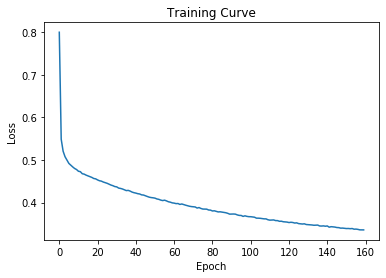

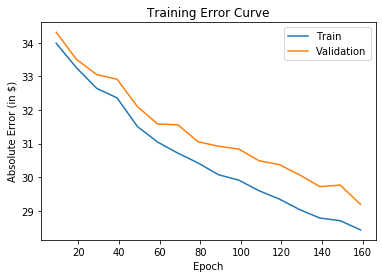

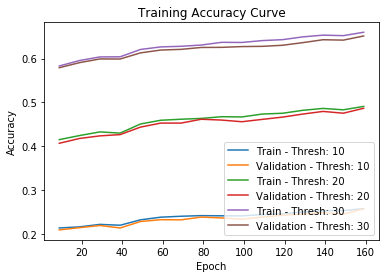

---[ITER 10] loss: 0.349540  time: 2.625
---[ITER 20] loss: 0.343688  time: 2.521
---[ITER 30] loss: 0.341957  time: 2.566
---[ITER 40] loss: 0.321262  time: 2.482
---[ITER 50] loss: 0.325019  time: 2.517
---[ITER 60] loss: 0.330733  time: 2.553
---[ITER 70] loss: 0.331001  time: 2.556
---[ITER 80] loss: 0.340381  time: 2.501
---[ITER 90] loss: 0.325160  time: 2.606
---[ITER 100] loss: 0.332166  time: 2.614
---[ITER 110] loss: 0.342476  time: 2.566
---[ITER 120] loss: 0.330151  time: 2.555
---[ITER 130] loss: 0.335662  time: 2.512
---[ITER 140] loss: 0.335887  time: 2.539
---[ITER 150] loss: 0.339285  time: 2.645
---[ITER 160] loss: 0.333220  time: 2.524
[EPOCH 161] loss: 0.334898  time: 42.862
---[ITER 10] loss: 0.330479  time: 2.573
---[ITER 20] loss: 0.331986  time: 2.551
---[ITER 30] loss: 0.330114  time: 2.493
---[ITER 40] loss: 0.327246  time: 2.526
---[ITER 50] loss: 0.338033  time: 2.493
---[ITER 60] loss: 0.341829  time: 2.535
---[ITER 70] loss: 0.343809  time: 2.497
---[ITER 

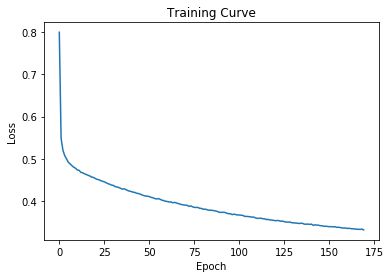

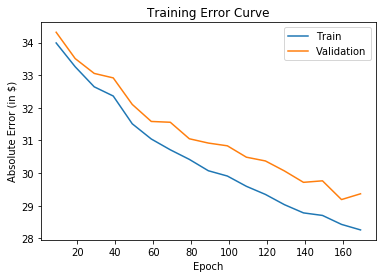

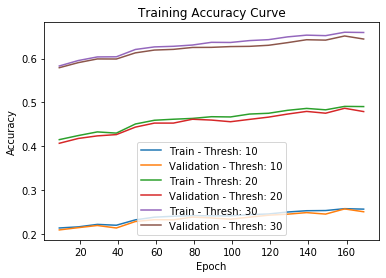

---[ITER 10] loss: 0.333839  time: 2.577
---[ITER 20] loss: 0.336301  time: 2.591
---[ITER 30] loss: 0.328033  time: 2.579
---[ITER 40] loss: 0.339773  time: 2.539
---[ITER 50] loss: 0.320912  time: 2.590
---[ITER 60] loss: 0.317431  time: 2.546
---[ITER 70] loss: 0.342553  time: 2.572
---[ITER 80] loss: 0.307290  time: 2.535
---[ITER 90] loss: 0.318601  time: 2.566
---[ITER 100] loss: 0.328463  time: 2.541
---[ITER 110] loss: 0.338896  time: 2.581
---[ITER 120] loss: 0.331067  time: 3.311
---[ITER 130] loss: 0.330919  time: 2.972
---[ITER 140] loss: 0.328658  time: 2.844
---[ITER 150] loss: 0.334366  time: 2.571
---[ITER 160] loss: 0.348742  time: 6.899
[EPOCH 171] loss: 0.330547  time: 49.347
---[ITER 10] loss: 0.328426  time: 2.751
---[ITER 20] loss: 0.323803  time: 2.726
---[ITER 30] loss: 0.335812  time: 2.562
---[ITER 40] loss: 0.318345  time: 2.588
---[ITER 50] loss: 0.318842  time: 3.709
---[ITER 60] loss: 0.328605  time: 2.665
---[ITER 70] loss: 0.335293  time: 2.555
---[ITER 

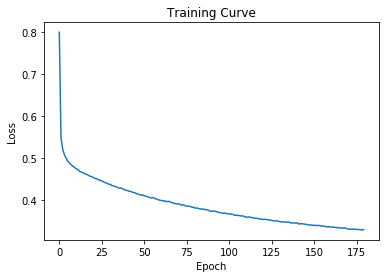

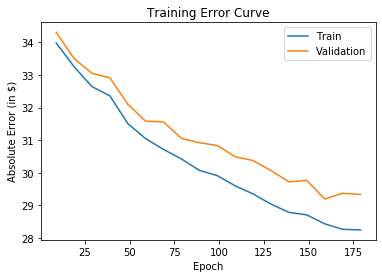

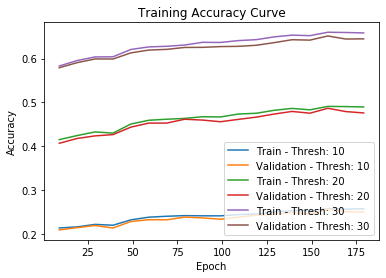

---[ITER 10] loss: 0.337388  time: 2.753
---[ITER 20] loss: 0.329345  time: 2.504
---[ITER 30] loss: 0.335514  time: 2.551
---[ITER 40] loss: 0.333203  time: 2.547
---[ITER 50] loss: 0.314076  time: 2.556
---[ITER 60] loss: 0.332510  time: 2.515
---[ITER 70] loss: 0.326144  time: 2.558
---[ITER 80] loss: 0.332069  time: 2.564
---[ITER 90] loss: 0.330049  time: 2.692
---[ITER 100] loss: 0.329039  time: 2.533
---[ITER 110] loss: 0.326474  time: 2.577
---[ITER 120] loss: 0.328909  time: 2.505
---[ITER 130] loss: 0.326480  time: 2.511
---[ITER 140] loss: 0.323283  time: 2.582
---[ITER 150] loss: 0.328671  time: 2.532
---[ITER 160] loss: 0.319877  time: 2.525
[EPOCH 181] loss: 0.327908  time: 42.984
---[ITER 10] loss: 0.327520  time: 2.579
---[ITER 20] loss: 0.318921  time: 2.539
---[ITER 30] loss: 0.314333  time: 2.503
---[ITER 40] loss: 0.320500  time: 2.587
---[ITER 50] loss: 0.326323  time: 2.548
---[ITER 60] loss: 0.317038  time: 2.515
---[ITER 70] loss: 0.334129  time: 2.520
---[ITER 

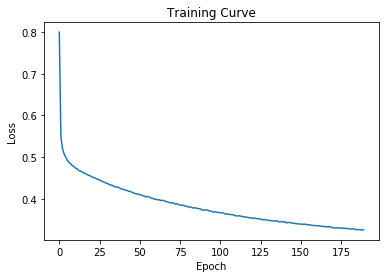

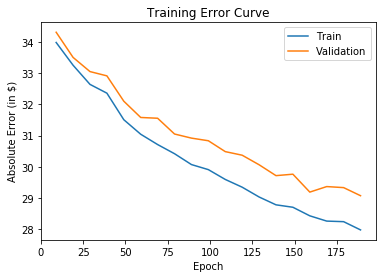

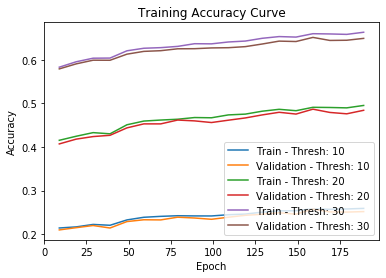

---[ITER 10] loss: 0.333542  time: 2.596
---[ITER 20] loss: 0.320373  time: 2.565
---[ITER 30] loss: 0.335207  time: 2.568
---[ITER 40] loss: 0.315039  time: 2.523
---[ITER 50] loss: 0.325427  time: 2.557
---[ITER 60] loss: 0.322965  time: 2.517
---[ITER 70] loss: 0.327767  time: 2.557
---[ITER 80] loss: 0.314475  time: 2.566
---[ITER 90] loss: 0.321372  time: 2.528
---[ITER 100] loss: 0.331950  time: 2.518
---[ITER 110] loss: 0.331318  time: 2.525
---[ITER 120] loss: 0.334984  time: 2.536
---[ITER 130] loss: 0.311516  time: 2.562
---[ITER 140] loss: 0.324578  time: 2.629
---[ITER 150] loss: 0.326880  time: 2.568
---[ITER 160] loss: 0.332331  time: 2.563
[EPOCH 191] loss: 0.325680  time: 42.834
---[ITER 10] loss: 0.311901  time: 2.678
---[ITER 20] loss: 0.320262  time: 2.563
---[ITER 30] loss: 0.317355  time: 2.540
---[ITER 40] loss: 0.332347  time: 2.540
---[ITER 50] loss: 0.329437  time: 2.549
---[ITER 60] loss: 0.324623  time: 2.517
---[ITER 70] loss: 0.322288  time: 2.525
---[ITER 

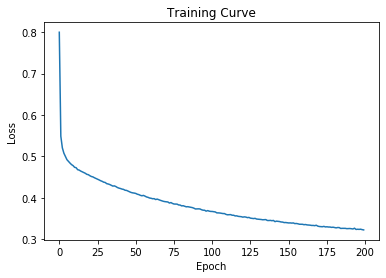

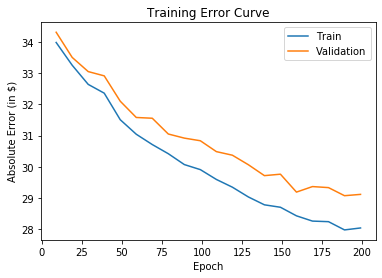

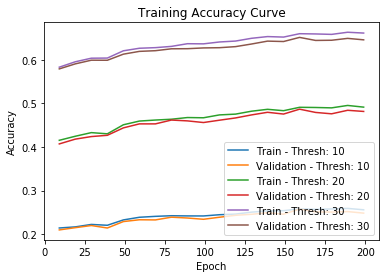

---[ITER 10] loss: 0.320807  time: 2.603
---[ITER 20] loss: 0.312186  time: 2.533
---[ITER 30] loss: 0.319953  time: 2.552
---[ITER 40] loss: 0.317203  time: 2.496
---[ITER 50] loss: 0.333948  time: 2.569
---[ITER 60] loss: 0.316642  time: 2.534
---[ITER 70] loss: 0.318286  time: 2.539
---[ITER 80] loss: 0.320416  time: 2.613
---[ITER 90] loss: 0.316658  time: 2.576
---[ITER 100] loss: 0.330164  time: 2.522
---[ITER 110] loss: 0.322847  time: 2.568
---[ITER 120] loss: 0.314348  time: 2.712
---[ITER 130] loss: 0.328472  time: 2.527
---[ITER 140] loss: 0.334567  time: 2.580
---[ITER 150] loss: 0.323215  time: 2.563
---[ITER 160] loss: 0.323405  time: 2.561
[EPOCH 201] loss: 0.322239  time: 43.106
---[ITER 10] loss: 0.328148  time: 2.797
---[ITER 20] loss: 0.318008  time: 2.556
---[ITER 30] loss: 0.318328  time: 2.563
---[ITER 40] loss: 0.310437  time: 2.606
---[ITER 50] loss: 0.316251  time: 2.501
---[ITER 60] loss: 0.311826  time: 2.522
---[ITER 70] loss: 0.317436  time: 2.546
---[ITER 

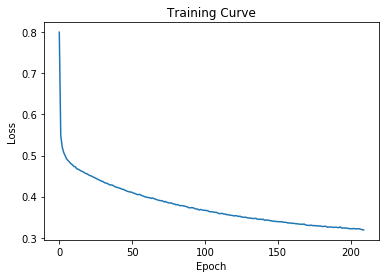

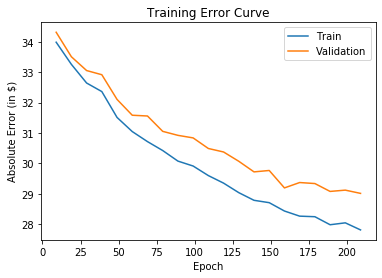

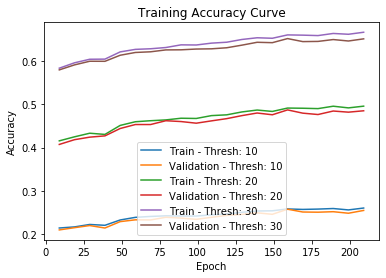

---[ITER 10] loss: 0.334778  time: 2.778
---[ITER 20] loss: 0.326962  time: 2.678
---[ITER 30] loss: 0.321626  time: 2.707
---[ITER 40] loss: 0.312446  time: 2.636
---[ITER 50] loss: 0.314563  time: 2.598
---[ITER 60] loss: 0.309286  time: 2.615
---[ITER 70] loss: 0.326324  time: 2.638
---[ITER 80] loss: 0.310127  time: 3.951
---[ITER 90] loss: 0.323097  time: 2.632
---[ITER 100] loss: 0.312801  time: 3.144
---[ITER 110] loss: 0.329447  time: 3.620
---[ITER 120] loss: 0.322389  time: 2.985
---[ITER 130] loss: 0.319051  time: 2.568
---[ITER 140] loss: 0.315666  time: 2.653
---[ITER 150] loss: 0.332683  time: 2.808
---[ITER 160] loss: 0.309147  time: 2.953
[EPOCH 211] loss: 0.319770  time: 48.373
---[ITER 10] loss: 0.317008  time: 3.185
---[ITER 20] loss: 0.319882  time: 2.982
---[ITER 30] loss: 0.339739  time: 3.308
---[ITER 40] loss: 0.327695  time: 4.217
---[ITER 50] loss: 0.309940  time: 7.684
---[ITER 60] loss: 0.317681  time: 6.727
---[ITER 70] loss: 0.317103  time: 11.257
---[ITER

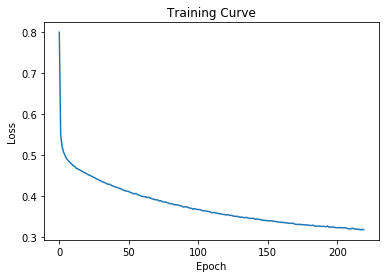

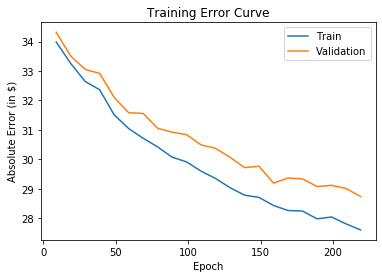

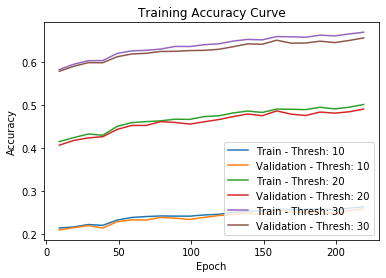

---[ITER 10] loss: 0.311828  time: 2.711
---[ITER 20] loss: 0.312540  time: 2.782
---[ITER 30] loss: 0.310325  time: 2.696
---[ITER 40] loss: 0.316045  time: 2.631
---[ITER 50] loss: 0.318221  time: 2.952
---[ITER 60] loss: 0.314238  time: 3.282
---[ITER 70] loss: 0.307967  time: 2.574
---[ITER 80] loss: 0.326357  time: 2.544
---[ITER 90] loss: 0.322427  time: 2.521
---[ITER 100] loss: 0.310434  time: 2.557
---[ITER 110] loss: 0.322232  time: 2.504
---[ITER 120] loss: 0.321795  time: 2.504
---[ITER 130] loss: 0.316671  time: 3.071
---[ITER 140] loss: 0.314654  time: 3.385
---[ITER 150] loss: 0.321437  time: 2.604
---[ITER 160] loss: 0.328617  time: 2.614
[EPOCH 221] loss: 0.317477  time: 46.507
---[ITER 10] loss: 0.327844  time: 2.854
---[ITER 20] loss: 0.311952  time: 2.699
---[ITER 30] loss: 0.312382  time: 4.591
---[ITER 40] loss: 0.321259  time: 3.322
---[ITER 50] loss: 0.311684  time: 2.866
---[ITER 60] loss: 0.314859  time: 2.724
---[ITER 70] loss: 0.305662  time: 3.374
---[ITER 

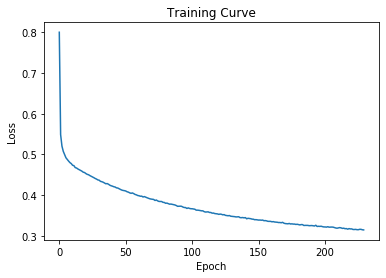

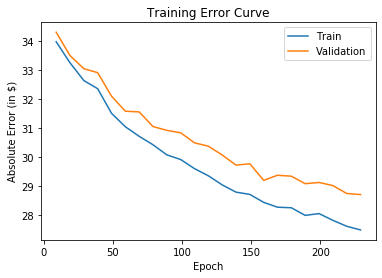

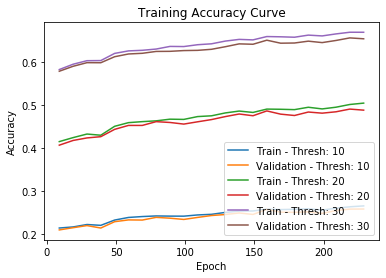

---[ITER 10] loss: 0.315100  time: 2.998
---[ITER 20] loss: 0.305266  time: 2.568
---[ITER 30] loss: 0.321596  time: 2.635
---[ITER 40] loss: 0.317685  time: 2.615
---[ITER 50] loss: 0.311114  time: 2.603
---[ITER 60] loss: 0.321292  time: 2.599
---[ITER 70] loss: 0.322633  time: 2.581
---[ITER 80] loss: 0.319387  time: 2.557
---[ITER 90] loss: 0.310784  time: 2.731
---[ITER 100] loss: 0.319400  time: 2.557
---[ITER 110] loss: 0.325771  time: 3.965
---[ITER 120] loss: 0.303060  time: 2.665
---[ITER 130] loss: 0.317330  time: 3.037
---[ITER 140] loss: 0.314201  time: 3.003
---[ITER 150] loss: 0.307411  time: 3.521
---[ITER 160] loss: 0.312913  time: 2.683
[EPOCH 231] loss: 0.315076  time: 47.321
---[ITER 10] loss: 0.319466  time: 2.516
---[ITER 20] loss: 0.322540  time: 3.181
---[ITER 30] loss: 0.323101  time: 2.614
---[ITER 40] loss: 0.319752  time: 3.304
---[ITER 50] loss: 0.308055  time: 3.096
---[ITER 60] loss: 0.309574  time: 3.056
---[ITER 70] loss: 0.321514  time: 3.397
---[ITER 

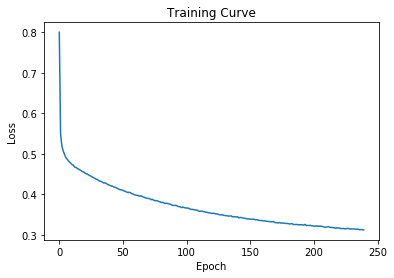

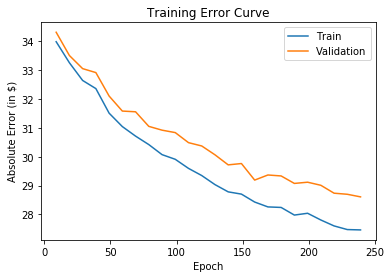

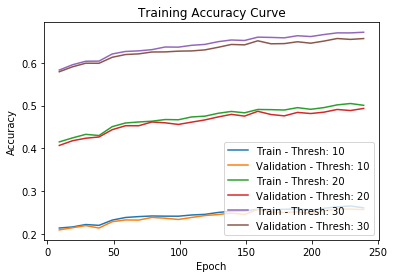

---[ITER 10] loss: 0.322796  time: 2.674
---[ITER 20] loss: 0.311687  time: 3.610
---[ITER 30] loss: 0.307683  time: 2.683
---[ITER 40] loss: 0.309438  time: 2.619
---[ITER 50] loss: 0.310271  time: 2.641
---[ITER 60] loss: 0.314226  time: 3.779
---[ITER 70] loss: 0.314640  time: 3.305
---[ITER 80] loss: 0.318461  time: 2.624
---[ITER 90] loss: 0.310469  time: 2.584
---[ITER 100] loss: 0.306787  time: 2.714
---[ITER 110] loss: 0.311960  time: 2.801
---[ITER 120] loss: 0.307704  time: 2.665
---[ITER 130] loss: 0.315780  time: 2.792
---[ITER 140] loss: 0.319008  time: 2.787
---[ITER 150] loss: 0.305987  time: 2.685
---[ITER 160] loss: 0.317586  time: 3.028
[EPOCH 241] loss: 0.313434  time: 48.322
---[ITER 10] loss: 0.327846  time: 2.690
---[ITER 20] loss: 0.304842  time: 2.542
---[ITER 30] loss: 0.317862  time: 2.856
---[ITER 40] loss: 0.322892  time: 2.638
---[ITER 50] loss: 0.308852  time: 2.555
---[ITER 60] loss: 0.319773  time: 2.744
---[ITER 70] loss: 0.302810  time: 3.044
---[ITER 

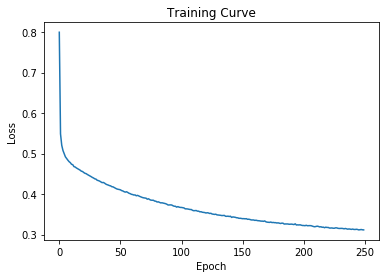

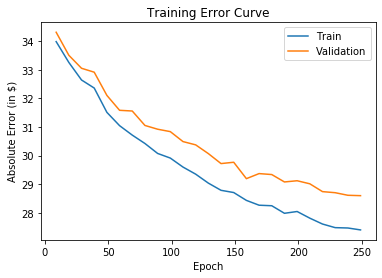

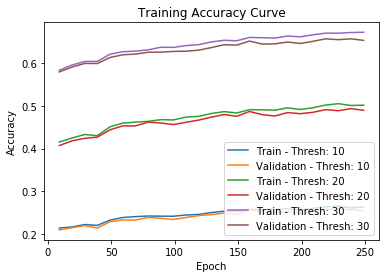

---[ITER 10] loss: 0.316024  time: 2.599
---[ITER 20] loss: 0.298355  time: 2.579
---[ITER 30] loss: 0.316824  time: 2.618
---[ITER 40] loss: 0.318539  time: 3.182
---[ITER 50] loss: 0.309571  time: 4.512
---[ITER 60] loss: 0.314759  time: 134.965
---[ITER 70] loss: 0.311110  time: 21.646
---[ITER 80] loss: 0.317217  time: 12.333
---[ITER 90] loss: 0.319292  time: 4.756
---[ITER 100] loss: 0.296565  time: 4.023
---[ITER 110] loss: 0.310451  time: 3.517
---[ITER 120] loss: 0.300732  time: 3.283
---[ITER 130] loss: 0.305506  time: 4.457
---[ITER 140] loss: 0.317545  time: 51.339
---[ITER 150] loss: 0.323133  time: 3.479
---[ITER 160] loss: 0.306155  time: 2.929
[EPOCH 251] loss: 0.310806  time: 264.565
---[ITER 10] loss: 0.302744  time: 14.517
---[ITER 20] loss: 0.305262  time: 3.628
---[ITER 30] loss: 0.314932  time: 4.464
---[ITER 40] loss: 0.319187  time: 4.881
---[ITER 50] loss: 0.311460  time: 5.121
---[ITER 60] loss: 0.307754  time: 4.792
---[ITER 70] loss: 0.302802  time: 3.746
--

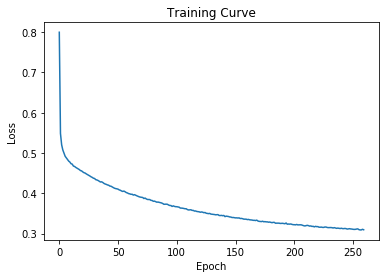

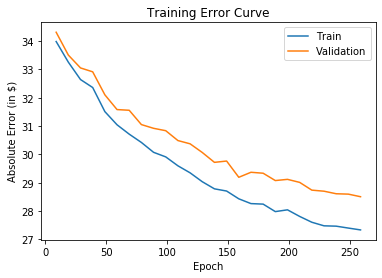

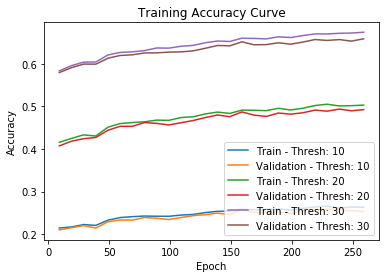

---[ITER 10] loss: 0.313979  time: 3.345
---[ITER 20] loss: 0.301696  time: 3.161
---[ITER 30] loss: 0.315957  time: 3.655
---[ITER 40] loss: 0.315516  time: 3.143
---[ITER 50] loss: 0.311537  time: 4.039
---[ITER 60] loss: 0.309559  time: 4.301
---[ITER 70] loss: 0.311004  time: 3.883
---[ITER 80] loss: 0.311681  time: 3.774
---[ITER 90] loss: 0.306215  time: 3.915
---[ITER 100] loss: 0.317378  time: 2.730
---[ITER 110] loss: 0.300493  time: 2.751
---[ITER 120] loss: 0.307151  time: 2.678
---[ITER 130] loss: 0.301950  time: 3.500
---[ITER 140] loss: 0.323300  time: 2.716
---[ITER 150] loss: 0.311992  time: 2.705
---[ITER 160] loss: 0.308726  time: 3.136
[EPOCH 261] loss: 0.310405  time: 55.523
---[ITER 10] loss: 0.309680  time: 2.689
---[ITER 20] loss: 0.308616  time: 2.705
---[ITER 30] loss: 0.312084  time: 2.680
---[ITER 40] loss: 0.308783  time: 2.640
---[ITER 50] loss: 0.304285  time: 2.680
---[ITER 60] loss: 0.305021  time: 2.643
---[ITER 70] loss: 0.310149  time: 3.358
---[ITER 

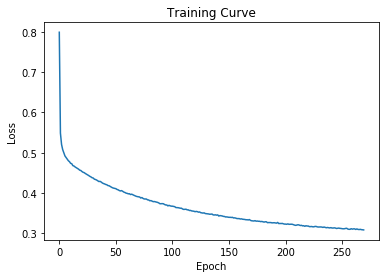

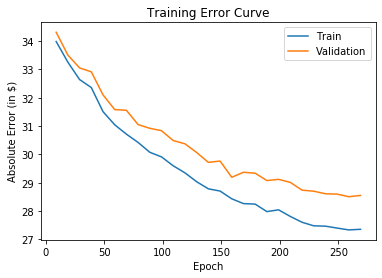

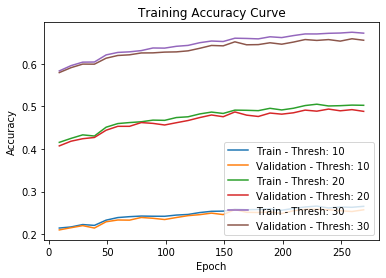

---[ITER 10] loss: 0.295459  time: 3.561
---[ITER 20] loss: 0.312996  time: 3.273
---[ITER 30] loss: 0.307822  time: 3.195
---[ITER 40] loss: 0.320843  time: 3.148
---[ITER 50] loss: 0.297618  time: 3.110
---[ITER 60] loss: 0.308991  time: 3.453
---[ITER 70] loss: 0.309180  time: 3.538
---[ITER 80] loss: 0.306505  time: 3.114
---[ITER 90] loss: 0.308882  time: 3.463
---[ITER 100] loss: 0.318552  time: 3.381
---[ITER 110] loss: 0.310855  time: 3.220
---[ITER 120] loss: 0.313555  time: 3.104
---[ITER 130] loss: 0.286746  time: 3.274
---[ITER 140] loss: 0.299875  time: 5.601
---[ITER 150] loss: 0.314810  time: 3.394
---[ITER 160] loss: 0.311492  time: 3.343
[EPOCH 271] loss: 0.308041  time: 58.200
---[ITER 10] loss: 0.315658  time: 4.621
---[ITER 20] loss: 0.309642  time: 7.068
---[ITER 30] loss: 0.318738  time: 3.325
---[ITER 40] loss: 0.306336  time: 3.311
---[ITER 50] loss: 0.303158  time: 4.028
---[ITER 60] loss: 0.311591  time: 5.868
---[ITER 70] loss: 0.302654  time: 3.503
---[ITER 

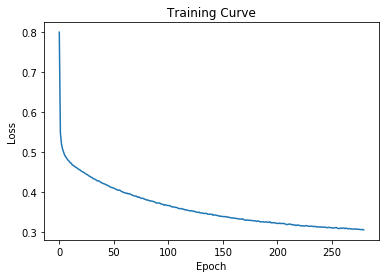

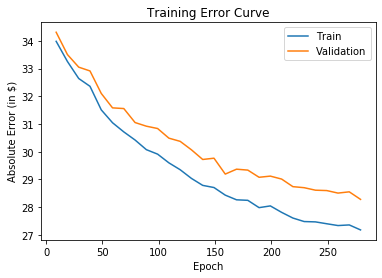

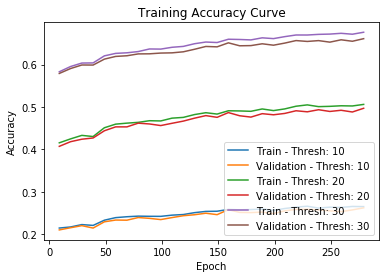

---[ITER 10] loss: 0.299028  time: 3.659
---[ITER 20] loss: 0.307866  time: 3.506
---[ITER 30] loss: 0.306817  time: 5.257
---[ITER 40] loss: 0.303031  time: 4.313
---[ITER 50] loss: 0.304371  time: 4.278
---[ITER 60] loss: 0.304361  time: 4.257
---[ITER 70] loss: 0.307933  time: 4.013
---[ITER 80] loss: 0.313664  time: 3.710
---[ITER 90] loss: 0.304312  time: 3.272
---[ITER 100] loss: 0.311577  time: 4.352
---[ITER 110] loss: 0.307670  time: 4.987
---[ITER 120] loss: 0.300641  time: 4.614
---[ITER 130] loss: 0.310059  time: 3.587
---[ITER 140] loss: 0.311825  time: 3.471
---[ITER 150] loss: 0.305784  time: 4.031
---[ITER 160] loss: 0.303163  time: 3.920
[EPOCH 281] loss: 0.306197  time: 68.831
---[ITER 10] loss: 0.304294  time: 3.439
---[ITER 20] loss: 0.310351  time: 3.578
---[ITER 30] loss: 0.291318  time: 3.299
---[ITER 40] loss: 0.309998  time: 4.010
---[ITER 50] loss: 0.304345  time: 3.633
---[ITER 60] loss: 0.303030  time: 4.076
---[ITER 70] loss: 0.315669  time: 3.309
---[ITER 

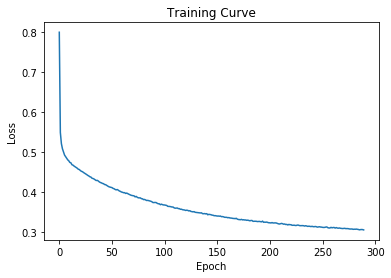

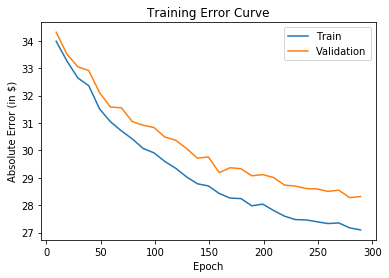

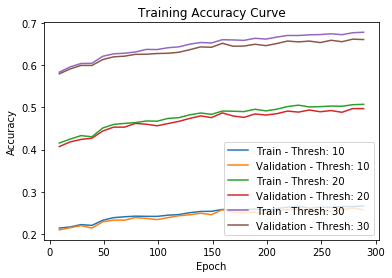

---[ITER 10] loss: 0.304136  time: 4.121
---[ITER 20] loss: 0.304627  time: 3.281
---[ITER 30] loss: 0.297547  time: 3.675
---[ITER 40] loss: 0.299981  time: 3.727
---[ITER 50] loss: 0.302594  time: 3.535
---[ITER 60] loss: 0.311128  time: 3.276
---[ITER 70] loss: 0.298724  time: 3.152
---[ITER 80] loss: 0.302355  time: 3.447
---[ITER 90] loss: 0.309961  time: 3.172
---[ITER 100] loss: 0.307435  time: 3.142
---[ITER 110] loss: 0.318760  time: 3.074
---[ITER 120] loss: 0.298171  time: 3.088
---[ITER 130] loss: 0.301024  time: 3.045
---[ITER 140] loss: 0.293851  time: 3.072
---[ITER 150] loss: 0.305197  time: 3.086
---[ITER 160] loss: 0.312683  time: 3.064
[EPOCH 291] loss: 0.303828  time: 55.332
---[ITER 10] loss: 0.305489  time: 3.095
---[ITER 20] loss: 0.309184  time: 3.114
---[ITER 30] loss: 0.301917  time: 3.321
---[ITER 40] loss: 0.324873  time: 3.112
---[ITER 50] loss: 0.306643  time: 3.347
---[ITER 60] loss: 0.296691  time: 3.261
---[ITER 70] loss: 0.308854  time: 3.043
---[ITER 

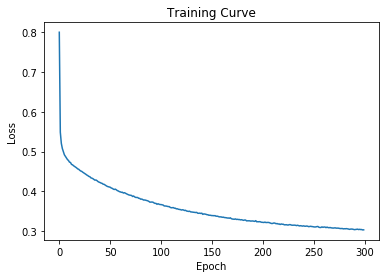

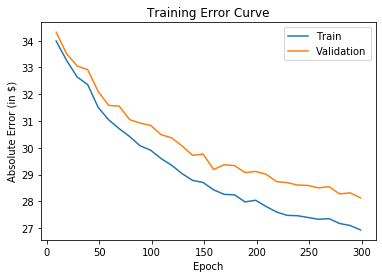

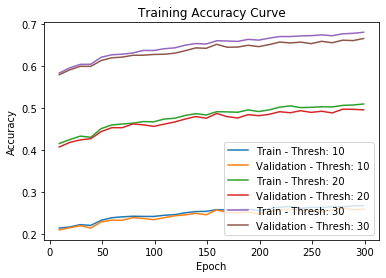

---[ITER 10] loss: 0.318302  time: 2.752
---[ITER 20] loss: 0.299935  time: 2.719
---[ITER 30] loss: 0.308020  time: 2.703
---[ITER 40] loss: 0.314883  time: 2.666
---[ITER 50] loss: 0.291750  time: 2.594
---[ITER 60] loss: 0.296522  time: 2.696
---[ITER 70] loss: 0.316969  time: 2.681
---[ITER 80] loss: 0.303117  time: 2.630
---[ITER 90] loss: 0.289451  time: 2.628
---[ITER 100] loss: 0.306393  time: 2.633
---[ITER 110] loss: 0.315753  time: 2.594
---[ITER 120] loss: 0.306964  time: 2.693
---[ITER 130] loss: 0.299562  time: 2.649
---[ITER 140] loss: 0.298585  time: 2.675
---[ITER 150] loss: 0.296757  time: 2.602
---[ITER 160] loss: 0.301525  time: 2.678
[EPOCH 301] loss: 0.303471  time: 44.628
---[ITER 10] loss: 0.320184  time: 2.675
---[ITER 20] loss: 0.297236  time: 2.666
---[ITER 30] loss: 0.309234  time: 2.955
---[ITER 40] loss: 0.296732  time: 2.649
---[ITER 50] loss: 0.299399  time: 2.582
---[ITER 60] loss: 0.307576  time: 2.634
---[ITER 70] loss: 0.291555  time: 2.752
---[ITER 

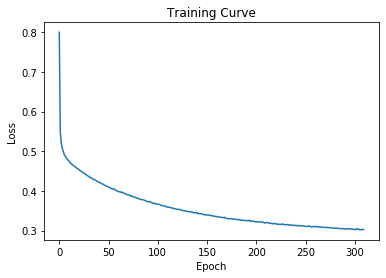

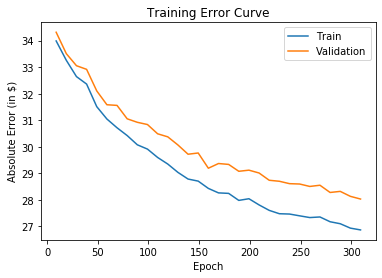

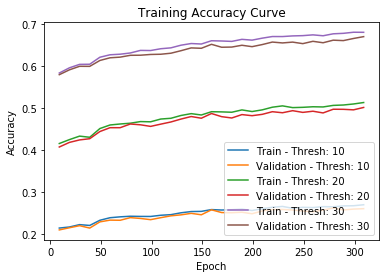

---[ITER 10] loss: 0.314911  time: 3.073
---[ITER 20] loss: 0.299404  time: 3.011
---[ITER 30] loss: 0.301459  time: 3.042
---[ITER 40] loss: 0.302771  time: 2.966
---[ITER 50] loss: 0.308103  time: 3.006
---[ITER 60] loss: 0.296637  time: 2.914
---[ITER 70] loss: 0.305666  time: 2.803
---[ITER 80] loss: 0.294858  time: 2.800
---[ITER 90] loss: 0.303170  time: 2.761
---[ITER 100] loss: 0.306440  time: 2.860
---[ITER 110] loss: 0.290675  time: 2.947
---[ITER 120] loss: 0.301147  time: 3.017
---[ITER 130] loss: 0.318640  time: 2.742
---[ITER 140] loss: 0.305186  time: 2.925
---[ITER 150] loss: 0.309244  time: 3.055
---[ITER 160] loss: 0.285154  time: 3.499
[EPOCH 311] loss: 0.303068  time: 49.561
---[ITER 10] loss: 0.293394  time: 2.999
---[ITER 20] loss: 0.301708  time: 3.223
---[ITER 30] loss: 0.307120  time: 2.872
---[ITER 40] loss: 0.305224  time: 3.469
---[ITER 50] loss: 0.293370  time: 3.783
---[ITER 60] loss: 0.305453  time: 3.362
---[ITER 70] loss: 0.291127  time: 3.370
---[ITER 

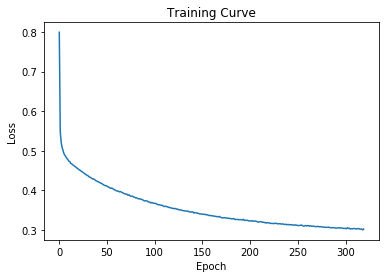

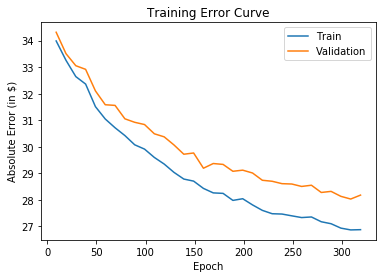

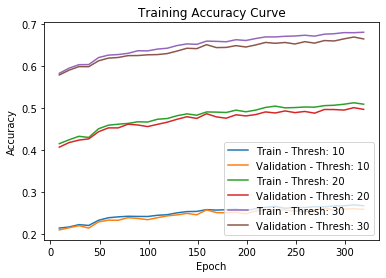

---[ITER 10] loss: 0.295678  time: 2.863
---[ITER 20] loss: 0.296403  time: 2.872
---[ITER 30] loss: 0.307032  time: 2.953
---[ITER 40] loss: 0.298321  time: 2.775
---[ITER 50] loss: 0.298800  time: 2.822
---[ITER 60] loss: 0.294267  time: 2.678
---[ITER 70] loss: 0.295011  time: 2.728
---[ITER 80] loss: 0.288623  time: 2.673
---[ITER 90] loss: 0.314583  time: 2.645
---[ITER 100] loss: 0.297748  time: 2.665
---[ITER 110] loss: 0.293372  time: 2.953
---[ITER 120] loss: 0.306624  time: 2.809
---[ITER 130] loss: 0.315394  time: 2.739
---[ITER 140] loss: 0.301813  time: 2.813
---[ITER 150] loss: 0.298275  time: 2.785
---[ITER 160] loss: 0.299012  time: 2.796
[EPOCH 321] loss: 0.300618  time: 46.667
---[ITER 10] loss: 0.297936  time: 2.725
---[ITER 20] loss: 0.311486  time: 2.715
---[ITER 30] loss: 0.308243  time: 2.778
---[ITER 40] loss: 0.299349  time: 2.790
---[ITER 50] loss: 0.298920  time: 2.685
---[ITER 60] loss: 0.300845  time: 2.693
---[ITER 70] loss: 0.299043  time: 2.647
---[ITER 

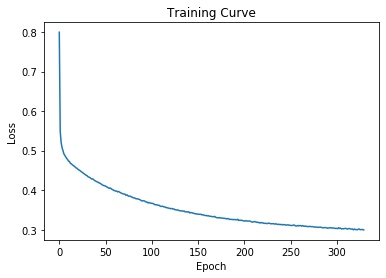

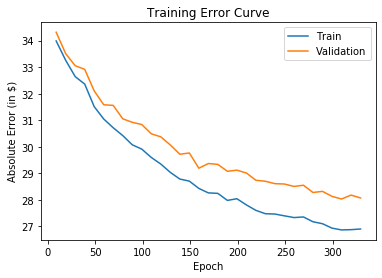

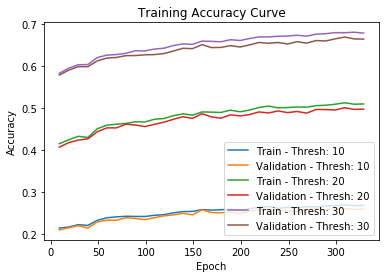

---[ITER 10] loss: 0.299449  time: 4.044
---[ITER 20] loss: 0.304819  time: 4.111
---[ITER 30] loss: 0.296545  time: 2.921
---[ITER 40] loss: 0.294247  time: 6.234
---[ITER 50] loss: 0.298822  time: 3.277
---[ITER 60] loss: 0.293515  time: 3.501
---[ITER 70] loss: 0.310078  time: 3.547
---[ITER 80] loss: 0.307240  time: 3.298
---[ITER 90] loss: 0.293605  time: 4.098
---[ITER 100] loss: 0.301160  time: 2.927
---[ITER 110] loss: 0.293395  time: 3.690
---[ITER 120] loss: 0.286478  time: 3.021
---[ITER 130] loss: 0.294391  time: 3.376
---[ITER 140] loss: 0.298234  time: 3.448
---[ITER 150] loss: 0.301912  time: 2.831
---[ITER 160] loss: 0.299887  time: 3.068
[EPOCH 331] loss: 0.298862  time: 59.740
---[ITER 10] loss: 0.309002  time: 2.862
---[ITER 20] loss: 0.302654  time: 3.603
---[ITER 30] loss: 0.288661  time: 2.776
---[ITER 40] loss: 0.306253  time: 2.813
---[ITER 50] loss: 0.303398  time: 3.393
---[ITER 60] loss: 0.293615  time: 2.734
---[ITER 70] loss: 0.299994  time: 2.601
---[ITER 

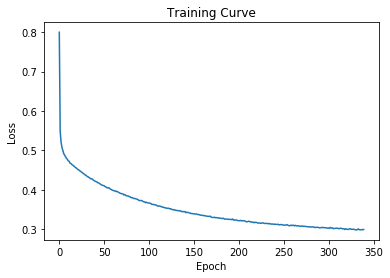

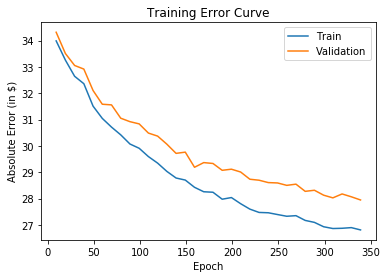

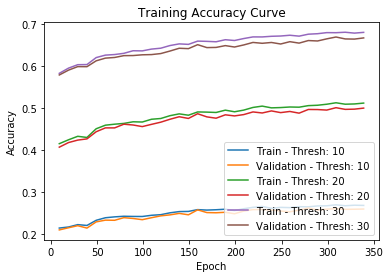

---[ITER 10] loss: 0.302606  time: 2.808
---[ITER 20] loss: 0.293174  time: 2.957
---[ITER 30] loss: 0.304013  time: 2.740
---[ITER 40] loss: 0.288942  time: 2.668
---[ITER 50] loss: 0.300848  time: 2.873
---[ITER 60] loss: 0.297654  time: 2.838
---[ITER 70] loss: 0.291637  time: 2.943
---[ITER 80] loss: 0.313503  time: 2.694
---[ITER 90] loss: 0.285321  time: 2.771
---[ITER 100] loss: 0.308720  time: 2.768
---[ITER 110] loss: 0.296384  time: 2.811
---[ITER 120] loss: 0.305101  time: 2.710
---[ITER 130] loss: 0.296168  time: 2.714
---[ITER 140] loss: 0.294335  time: 2.796
---[ITER 150] loss: 0.304124  time: 2.739
---[ITER 160] loss: 0.300498  time: 2.672
[EPOCH 341] loss: 0.298764  time: 46.639
---[ITER 10] loss: 0.287416  time: 2.751
---[ITER 20] loss: 0.309657  time: 2.791
---[ITER 30] loss: 0.290709  time: 2.731
---[ITER 40] loss: 0.296316  time: 2.773
---[ITER 50] loss: 0.301418  time: 2.783
---[ITER 60] loss: 0.297140  time: 2.790
---[ITER 70] loss: 0.306610  time: 2.748
---[ITER 

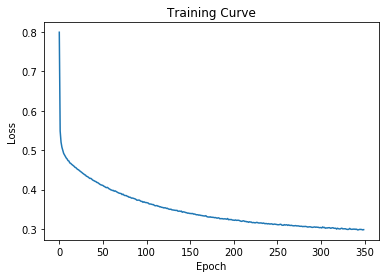

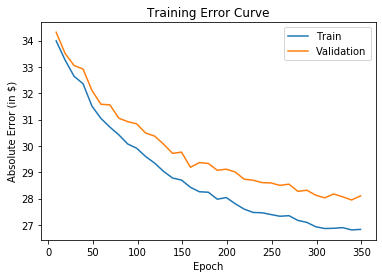

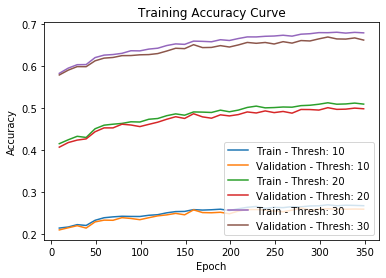

---[ITER 10] loss: 0.304048  time: 2.712
---[ITER 20] loss: 0.301685  time: 2.592
---[ITER 30] loss: 0.311583  time: 2.552
---[ITER 40] loss: 0.283257  time: 2.613
---[ITER 50] loss: 0.296008  time: 2.757
---[ITER 60] loss: 0.291048  time: 2.606
---[ITER 70] loss: 0.298230  time: 2.558
---[ITER 80] loss: 0.290256  time: 2.579
---[ITER 90] loss: 0.310581  time: 2.535
---[ITER 100] loss: 0.301626  time: 2.558
---[ITER 110] loss: 0.295419  time: 2.563
---[ITER 120] loss: 0.296733  time: 2.553
---[ITER 130] loss: 0.289667  time: 2.548
---[ITER 140] loss: 0.308575  time: 2.544
---[ITER 150] loss: 0.301584  time: 2.562
---[ITER 160] loss: 0.306610  time: 2.528
[EPOCH 351] loss: 0.299154  time: 43.344
---[ITER 10] loss: 0.298002  time: 2.538
---[ITER 20] loss: 0.297033  time: 2.552
---[ITER 30] loss: 0.294319  time: 2.525
---[ITER 40] loss: 0.312443  time: 2.551
---[ITER 50] loss: 0.281636  time: 2.506
---[ITER 60] loss: 0.298668  time: 2.523
---[ITER 70] loss: 0.304058  time: 2.584
---[ITER 

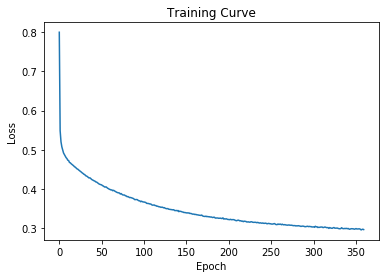

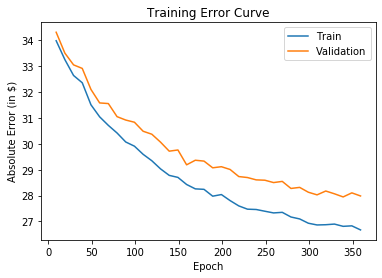

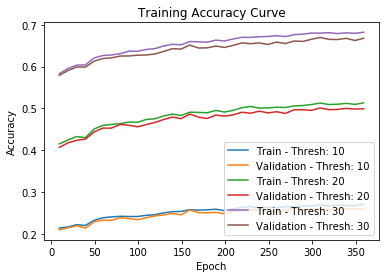

---[ITER 10] loss: 0.292783  time: 2.958
---[ITER 20] loss: 0.296336  time: 2.772
---[ITER 30] loss: 0.298989  time: 2.855
---[ITER 40] loss: 0.296983  time: 2.820
---[ITER 50] loss: 0.303201  time: 2.804
---[ITER 60] loss: 0.294752  time: 2.902
---[ITER 70] loss: 0.297952  time: 3.040
---[ITER 80] loss: 0.292699  time: 2.808
---[ITER 90] loss: 0.302596  time: 2.796
---[ITER 100] loss: 0.297594  time: 2.757
---[ITER 110] loss: 0.302434  time: 2.811
---[ITER 120] loss: 0.287202  time: 2.821
---[ITER 130] loss: 0.293894  time: 2.794
---[ITER 140] loss: 0.291281  time: 2.751
---[ITER 150] loss: 0.302929  time: 2.858
---[ITER 160] loss: 0.299422  time: 2.883
[EPOCH 361] loss: 0.297151  time: 47.810
---[ITER 10] loss: 0.304531  time: 2.641
---[ITER 20] loss: 0.295006  time: 2.633
---[ITER 30] loss: 0.286318  time: 2.668
---[ITER 40] loss: 0.303818  time: 2.602
---[ITER 50] loss: 0.313852  time: 2.713
---[ITER 60] loss: 0.298408  time: 2.855
---[ITER 70] loss: 0.294337  time: 2.844
---[ITER 

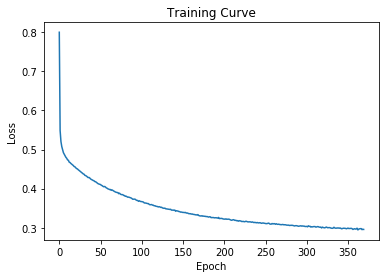

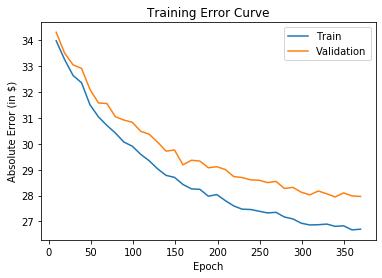

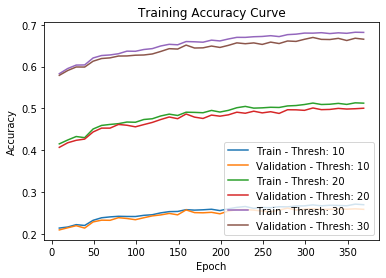

---[ITER 10] loss: 0.292527  time: 2.729
---[ITER 20] loss: 0.298106  time: 2.647
---[ITER 30] loss: 0.294598  time: 2.724
---[ITER 40] loss: 0.292578  time: 2.589
---[ITER 50] loss: 0.298079  time: 2.652
---[ITER 60] loss: 0.312146  time: 2.665
---[ITER 70] loss: 0.299966  time: 2.640
---[ITER 80] loss: 0.290589  time: 2.648
---[ITER 90] loss: 0.297084  time: 2.696
---[ITER 100] loss: 0.289565  time: 2.649
---[ITER 110] loss: 0.284969  time: 2.578
---[ITER 120] loss: 0.289021  time: 2.655
---[ITER 130] loss: 0.302933  time: 2.632
---[ITER 140] loss: 0.300877  time: 2.635
---[ITER 150] loss: 0.291618  time: 2.580
---[ITER 160] loss: 0.301405  time: 2.648
[EPOCH 371] loss: 0.295381  time: 44.488
---[ITER 10] loss: 0.288302  time: 2.673
---[ITER 20] loss: 0.286792  time: 2.644
---[ITER 30] loss: 0.306814  time: 2.703
---[ITER 40] loss: 0.304130  time: 2.684
---[ITER 50] loss: 0.304230  time: 2.672
---[ITER 60] loss: 0.303151  time: 2.608
---[ITER 70] loss: 0.289727  time: 2.650
---[ITER 

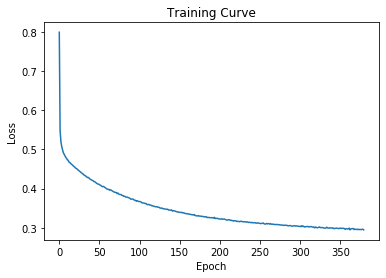

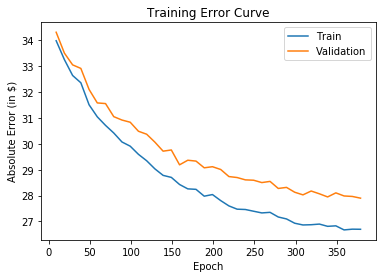

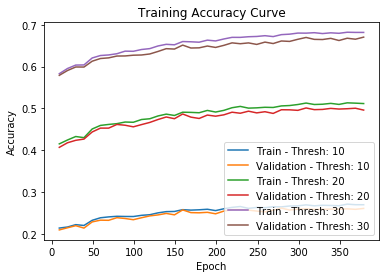

---[ITER 10] loss: 0.282431  time: 2.586
---[ITER 20] loss: 0.289037  time: 2.612
---[ITER 30] loss: 0.295881  time: 2.568
---[ITER 40] loss: 0.287523  time: 2.552
---[ITER 50] loss: 0.297461  time: 2.595
---[ITER 60] loss: 0.302782  time: 2.540
---[ITER 70] loss: 0.296826  time: 2.559
---[ITER 80] loss: 0.291023  time: 2.570
---[ITER 90] loss: 0.299598  time: 2.615
---[ITER 100] loss: 0.294119  time: 2.559
---[ITER 110] loss: 0.293708  time: 2.596
---[ITER 120] loss: 0.298782  time: 2.706
---[ITER 130] loss: 0.294201  time: 2.541
---[ITER 140] loss: 0.298991  time: 2.602
---[ITER 150] loss: 0.300311  time: 2.554
---[ITER 160] loss: 0.302971  time: 2.582
[EPOCH 381] loss: 0.295543  time: 43.326
---[ITER 10] loss: 0.299044  time: 2.594
---[ITER 20] loss: 0.304961  time: 2.613
---[ITER 30] loss: 0.299947  time: 2.574
---[ITER 40] loss: 0.297225  time: 2.677
---[ITER 50] loss: 0.281658  time: 2.721
---[ITER 60] loss: 0.298539  time: 2.594
---[ITER 70] loss: 0.289498  time: 2.548
---[ITER 

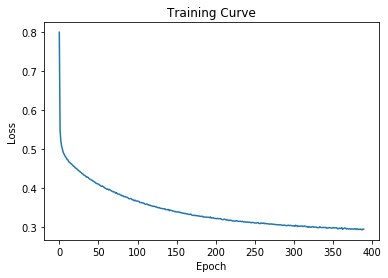

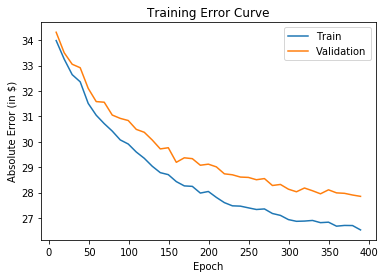

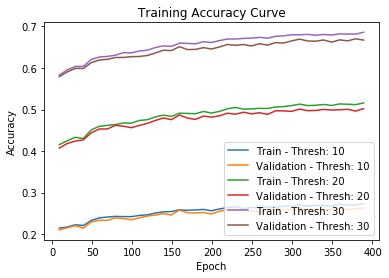

---[ITER 10] loss: 0.290658  time: 2.578
---[ITER 20] loss: 0.294390  time: 2.608
---[ITER 30] loss: 0.309835  time: 2.567
---[ITER 40] loss: 0.295526  time: 2.546
---[ITER 50] loss: 0.295906  time: 2.583
---[ITER 60] loss: 0.290379  time: 2.595
---[ITER 70] loss: 0.283350  time: 2.599
---[ITER 80] loss: 0.297565  time: 2.574
---[ITER 90] loss: 0.299367  time: 2.564
---[ITER 100] loss: 0.299764  time: 2.573
---[ITER 110] loss: 0.299045  time: 2.549
---[ITER 120] loss: 0.303441  time: 2.632
---[ITER 130] loss: 0.291843  time: 2.563
---[ITER 140] loss: 0.285477  time: 2.616
---[ITER 150] loss: 0.282481  time: 2.639
---[ITER 160] loss: 0.298112  time: 2.659
[EPOCH 391] loss: 0.295249  time: 43.442
---[ITER 10] loss: 0.298641  time: 2.730
---[ITER 20] loss: 0.292631  time: 2.638
---[ITER 30] loss: 0.288775  time: 2.692
---[ITER 40] loss: 0.291762  time: 2.578
---[ITER 50] loss: 0.291471  time: 2.652
---[ITER 60] loss: 0.291327  time: 2.611
---[ITER 70] loss: 0.299122  time: 2.621
---[ITER 

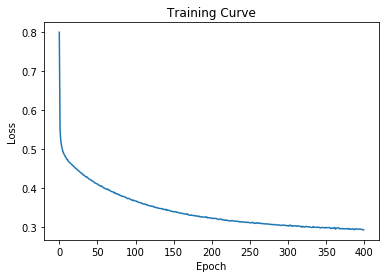

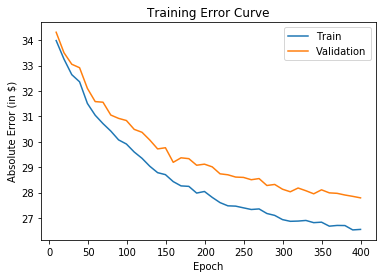

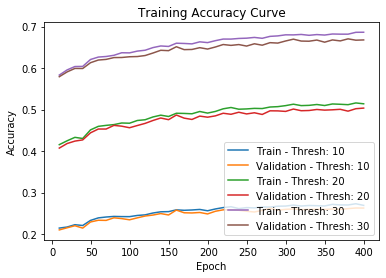

---[ITER 10] loss: 0.292824  time: 2.575
---[ITER 20] loss: 0.285544  time: 2.555
---[ITER 30] loss: 0.297835  time: 2.607
---[ITER 40] loss: 0.300149  time: 2.558
---[ITER 50] loss: 0.294618  time: 2.557
---[ITER 60] loss: 0.295182  time: 2.533
---[ITER 70] loss: 0.307531  time: 2.536
---[ITER 80] loss: 0.284284  time: 2.525
---[ITER 90] loss: 0.298513  time: 2.500
---[ITER 100] loss: 0.292856  time: 2.534
---[ITER 110] loss: 0.293248  time: 2.537
---[ITER 120] loss: 0.288560  time: 2.554
---[ITER 130] loss: 0.300831  time: 2.539
---[ITER 140] loss: 0.293089  time: 2.640
---[ITER 150] loss: 0.291886  time: 2.623
---[ITER 160] loss: 0.284713  time: 2.643
[EPOCH 401] loss: 0.293750  time: 43.002
---[ITER 10] loss: 0.285780  time: 2.757
---[ITER 20] loss: 0.290128  time: 2.692
---[ITER 30] loss: 0.299373  time: 2.617
---[ITER 40] loss: 0.293413  time: 2.554
---[ITER 50] loss: 0.290012  time: 2.590
---[ITER 60] loss: 0.278411  time: 2.638
---[ITER 70] loss: 0.300900  time: 2.563
---[ITER 

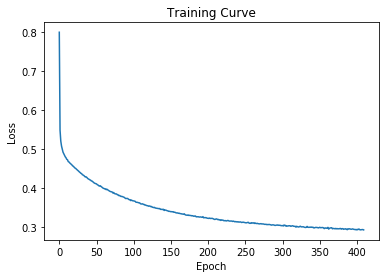

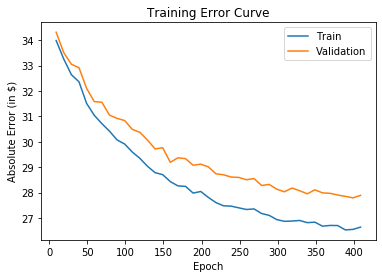

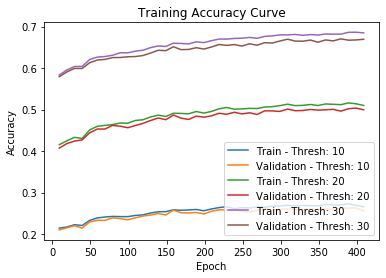

---[ITER 10] loss: 0.291364  time: 2.887
---[ITER 20] loss: 0.297840  time: 2.814
---[ITER 30] loss: 0.303628  time: 2.923
---[ITER 40] loss: 0.282736  time: 2.879
---[ITER 50] loss: 0.293525  time: 2.776
---[ITER 60] loss: 0.298387  time: 2.781
---[ITER 70] loss: 0.294145  time: 2.705
---[ITER 80] loss: 0.298594  time: 2.716
---[ITER 90] loss: 0.294634  time: 2.798
---[ITER 100] loss: 0.290828  time: 2.861
---[ITER 110] loss: 0.290124  time: 2.861
---[ITER 120] loss: 0.283773  time: 2.928
---[ITER 130] loss: 0.289895  time: 2.800
---[ITER 140] loss: 0.288531  time: 2.896
---[ITER 150] loss: 0.289489  time: 2.733
---[ITER 160] loss: 0.286574  time: 2.832
[EPOCH 411] loss: 0.292040  time: 47.274
---[ITER 10] loss: 0.292522  time: 2.962
---[ITER 20] loss: 0.293977  time: 2.840
---[ITER 30] loss: 0.306728  time: 2.747
---[ITER 40] loss: 0.293654  time: 2.773
---[ITER 50] loss: 0.297049  time: 2.728
---[ITER 60] loss: 0.290600  time: 2.807
---[ITER 70] loss: 0.286032  time: 2.987
---[ITER 

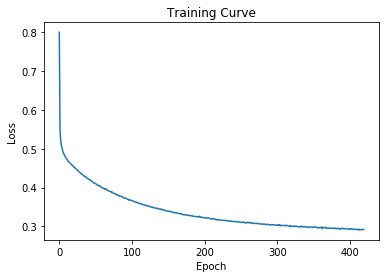

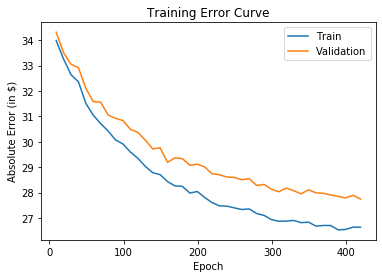

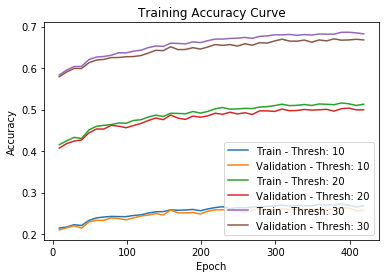

---[ITER 10] loss: 0.287258  time: 2.569
---[ITER 20] loss: 0.297506  time: 2.633
---[ITER 30] loss: 0.292006  time: 2.530
---[ITER 40] loss: 0.285657  time: 2.612
---[ITER 50] loss: 0.301346  time: 2.731
---[ITER 60] loss: 0.279635  time: 2.594
---[ITER 70] loss: 0.304307  time: 2.668
---[ITER 80] loss: 0.285004  time: 2.632
---[ITER 90] loss: 0.295994  time: 2.720
---[ITER 100] loss: 0.304859  time: 2.592
---[ITER 110] loss: 0.295158  time: 2.555
---[ITER 120] loss: 0.286798  time: 2.705
---[ITER 130] loss: 0.288836  time: 3.054
---[ITER 140] loss: 0.302625  time: 2.633
---[ITER 150] loss: 0.297488  time: 2.618
---[ITER 160] loss: 0.284166  time: 2.782
[EPOCH 421] loss: 0.292800  time: 44.599
---[ITER 10] loss: 0.294840  time: 2.648
---[ITER 20] loss: 0.292381  time: 2.810
---[ITER 30] loss: 0.292162  time: 2.639
---[ITER 40] loss: 0.312370  time: 2.714
---[ITER 50] loss: 0.280499  time: 2.829
---[ITER 60] loss: 0.287971  time: 2.822
---[ITER 70] loss: 0.290284  time: 2.646
---[ITER 

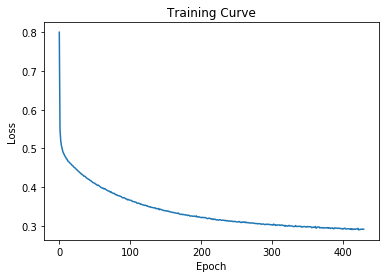

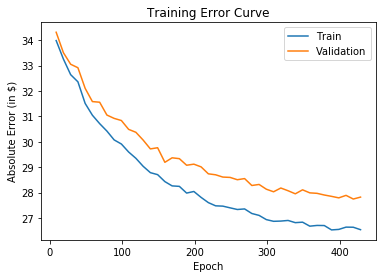

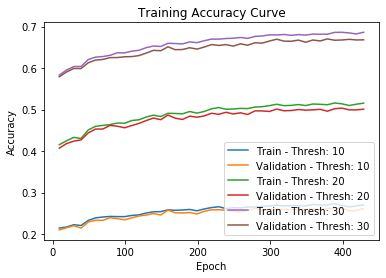

---[ITER 10] loss: 0.289964  time: 2.666
---[ITER 20] loss: 0.291324  time: 2.757
---[ITER 30] loss: 0.296370  time: 2.745
---[ITER 40] loss: 0.281900  time: 2.617
---[ITER 50] loss: 0.298695  time: 2.677
---[ITER 60] loss: 0.291518  time: 2.803
---[ITER 70] loss: 0.294869  time: 2.632
---[ITER 80] loss: 0.286079  time: 2.636
---[ITER 90] loss: 0.294545  time: 2.647
---[ITER 100] loss: 0.294459  time: 2.622
---[ITER 110] loss: 0.281057  time: 2.604
---[ITER 120] loss: 0.294035  time: 2.628
---[ITER 130] loss: 0.289690  time: 2.822
---[ITER 140] loss: 0.283106  time: 2.898
---[ITER 150] loss: 0.293696  time: 2.638
---[ITER 160] loss: 0.292745  time: 2.669
[EPOCH 431] loss: 0.290954  time: 45.157
---[ITER 10] loss: 0.285018  time: 2.607
---[ITER 20] loss: 0.290803  time: 2.642
---[ITER 30] loss: 0.294367  time: 2.631
---[ITER 40] loss: 0.282648  time: 2.669
---[ITER 50] loss: 0.283764  time: 2.593
---[ITER 60] loss: 0.304476  time: 2.656
---[ITER 70] loss: 0.296372  time: 2.668
---[ITER 

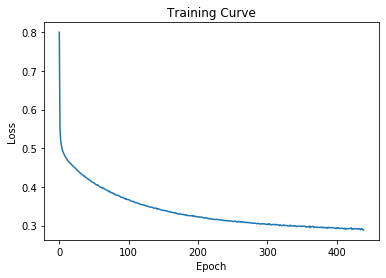

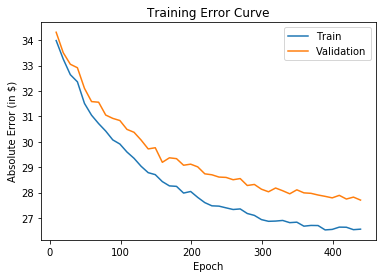

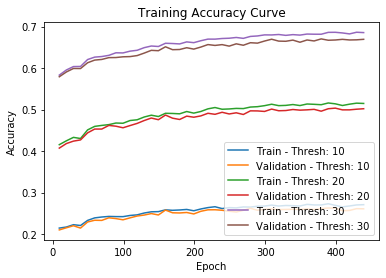

---[ITER 10] loss: 0.286350  time: 2.956
---[ITER 20] loss: 0.279878  time: 2.830
---[ITER 30] loss: 0.288991  time: 2.707
---[ITER 40] loss: 0.283314  time: 2.864
---[ITER 50] loss: 0.293712  time: 2.690
---[ITER 60] loss: 0.300755  time: 2.795
---[ITER 70] loss: 0.293745  time: 2.696
---[ITER 80] loss: 0.291752  time: 2.636
---[ITER 90] loss: 0.298415  time: 2.604
---[ITER 100] loss: 0.297658  time: 2.702
---[ITER 110] loss: 0.283954  time: 2.622
---[ITER 120] loss: 0.288731  time: 2.692
---[ITER 130] loss: 0.290564  time: 2.687
---[ITER 140] loss: 0.284054  time: 2.693
---[ITER 150] loss: 0.302330  time: 2.731
---[ITER 160] loss: 0.301995  time: 2.646
[EPOCH 441] loss: 0.290974  time: 45.603
---[ITER 10] loss: 0.282576  time: 2.663
---[ITER 20] loss: 0.293869  time: 2.646
---[ITER 30] loss: 0.298587  time: 2.677
---[ITER 40] loss: 0.281662  time: 2.677
---[ITER 50] loss: 0.289995  time: 2.624
---[ITER 60] loss: 0.285810  time: 2.677
---[ITER 70] loss: 0.281450  time: 2.754
---[ITER 

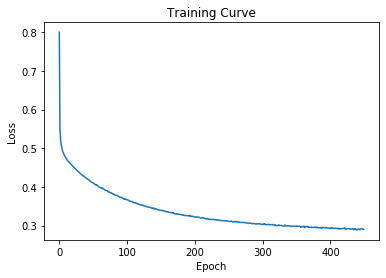

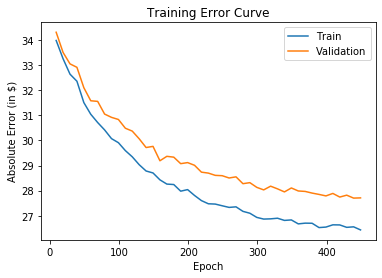

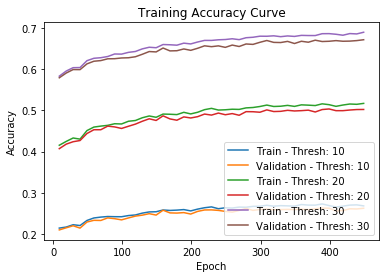

---[ITER 10] loss: 0.286989  time: 3.233
---[ITER 20] loss: 0.273015  time: 3.136
---[ITER 30] loss: 0.286070  time: 3.206
---[ITER 40] loss: 0.293823  time: 3.157
---[ITER 50] loss: 0.283641  time: 3.067
---[ITER 60] loss: 0.303759  time: 3.054
---[ITER 70] loss: 0.288364  time: 3.154
---[ITER 80] loss: 0.285618  time: 3.070
---[ITER 90] loss: 0.288078  time: 3.065
---[ITER 100] loss: 0.292831  time: 3.147
---[ITER 110] loss: 0.277119  time: 3.103
---[ITER 120] loss: 0.289878  time: 3.119
---[ITER 130] loss: 0.296080  time: 3.241
---[ITER 140] loss: 0.292899  time: 3.238
---[ITER 150] loss: 0.284372  time: 4.023
---[ITER 160] loss: 0.298274  time: 3.855
[EPOCH 451] loss: 0.288710  time: 54.824
---[ITER 10] loss: 0.286021  time: 3.657
---[ITER 20] loss: 0.295448  time: 3.483
---[ITER 30] loss: 0.293037  time: 3.448
---[ITER 40] loss: 0.293457  time: 3.843
---[ITER 50] loss: 0.297084  time: 3.912
---[ITER 60] loss: 0.291517  time: 3.761
---[ITER 70] loss: 0.288743  time: 3.484
---[ITER 

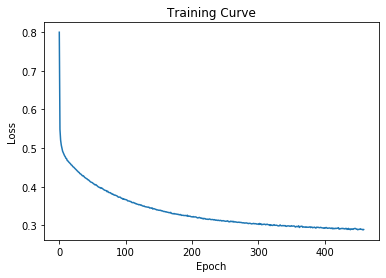

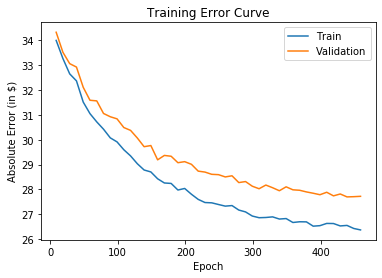

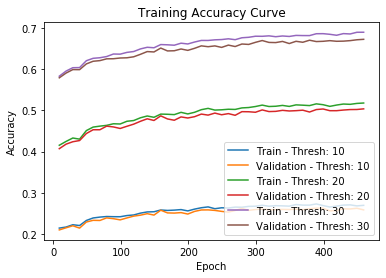

---[ITER 10] loss: 0.296421  time: 3.298
---[ITER 20] loss: 0.275503  time: 3.147
---[ITER 30] loss: 0.298666  time: 2.773
---[ITER 40] loss: 0.281143  time: 2.689
---[ITER 50] loss: 0.289932  time: 2.844
---[ITER 60] loss: 0.282938  time: 2.942
---[ITER 70] loss: 0.288382  time: 2.766
---[ITER 80] loss: 0.291720  time: 2.687
---[ITER 90] loss: 0.296003  time: 2.785
---[ITER 100] loss: 0.299760  time: 2.687
---[ITER 110] loss: 0.293827  time: 2.653
---[ITER 120] loss: 0.291477  time: 2.686
---[ITER 130] loss: 0.279421  time: 2.683
---[ITER 140] loss: 0.298773  time: 2.699
---[ITER 150] loss: 0.286498  time: 2.665
---[ITER 160] loss: 0.276555  time: 2.649
[EPOCH 461] loss: 0.289156  time: 46.674
---[ITER 10] loss: 0.279417  time: 2.628
---[ITER 20] loss: 0.294815  time: 2.664
---[ITER 30] loss: 0.291607  time: 2.591
---[ITER 40] loss: 0.287452  time: 2.617
---[ITER 50] loss: 0.281089  time: 2.612
---[ITER 60] loss: 0.292187  time: 2.580
---[ITER 70] loss: 0.290413  time: 2.646
---[ITER 

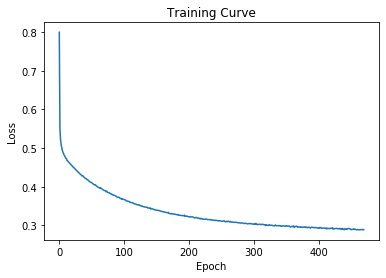

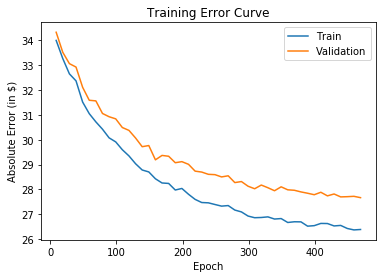

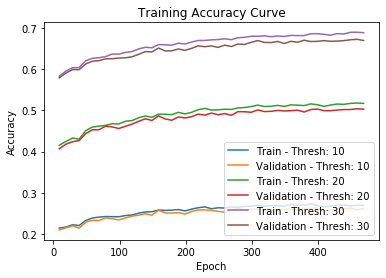

---[ITER 10] loss: 0.286641  time: 2.705
---[ITER 20] loss: 0.284538  time: 2.653
---[ITER 30] loss: 0.293081  time: 2.699
---[ITER 40] loss: 0.289779  time: 2.663
---[ITER 50] loss: 0.291143  time: 2.657
---[ITER 60] loss: 0.289175  time: 2.678
---[ITER 70] loss: 0.286191  time: 2.720
---[ITER 80] loss: 0.290810  time: 2.654
---[ITER 90] loss: 0.289883  time: 2.666
---[ITER 100] loss: 0.274495  time: 3.170
---[ITER 110] loss: 0.288102  time: 2.714
---[ITER 120] loss: 0.287114  time: 2.747
---[ITER 130] loss: 0.294558  time: 2.676
---[ITER 140] loss: 0.297808  time: 2.738
---[ITER 150] loss: 0.298334  time: 2.688
---[ITER 160] loss: 0.287884  time: 2.790
[EPOCH 471] loss: 0.289223  time: 45.742
---[ITER 10] loss: 0.294456  time: 2.765
---[ITER 20] loss: 0.294430  time: 2.765
---[ITER 30] loss: 0.285345  time: 2.675
---[ITER 40] loss: 0.304270  time: 2.661
---[ITER 50] loss: 0.286760  time: 2.589
---[ITER 60] loss: 0.291134  time: 2.591
---[ITER 70] loss: 0.278935  time: 2.575
---[ITER 

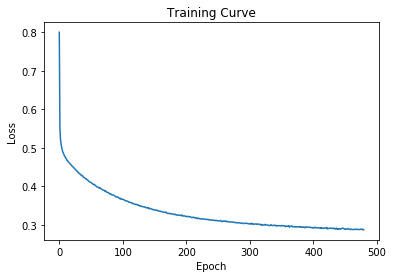

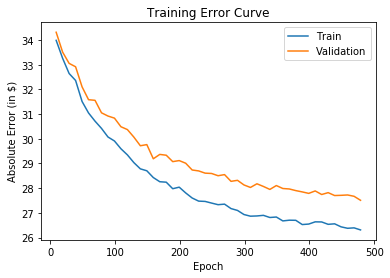

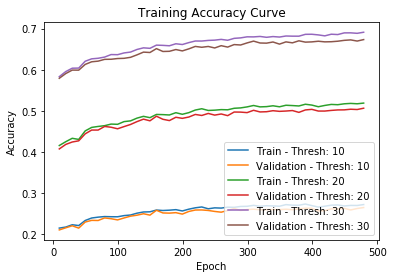

---[ITER 10] loss: 0.281937  time: 2.598
---[ITER 20] loss: 0.284986  time: 2.577
---[ITER 30] loss: 0.285758  time: 2.579
---[ITER 40] loss: 0.297183  time: 2.536
---[ITER 50] loss: 0.287712  time: 2.551
---[ITER 60] loss: 0.287165  time: 2.549
---[ITER 70] loss: 0.301496  time: 2.592
---[ITER 80] loss: 0.298115  time: 2.577
---[ITER 90] loss: 0.288140  time: 2.543
---[ITER 100] loss: 0.276203  time: 2.537
---[ITER 110] loss: 0.286715  time: 2.538
---[ITER 120] loss: 0.291443  time: 2.625
---[ITER 130] loss: 0.292966  time: 2.599
---[ITER 140] loss: 0.283846  time: 2.595
---[ITER 150] loss: 0.286644  time: 2.588
---[ITER 160] loss: 0.279963  time: 2.771
[EPOCH 481] loss: 0.288549  time: 43.332
---[ITER 10] loss: 0.287072  time: 2.610
---[ITER 20] loss: 0.292061  time: 2.583
---[ITER 30] loss: 0.281003  time: 2.591
---[ITER 40] loss: 0.290192  time: 2.553
---[ITER 50] loss: 0.282179  time: 2.560
---[ITER 60] loss: 0.285177  time: 2.556
---[ITER 70] loss: 0.298729  time: 2.593
---[ITER 

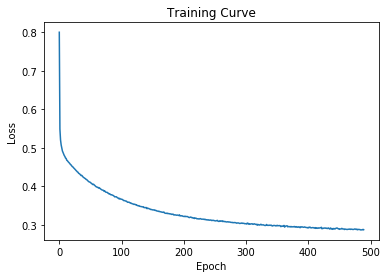

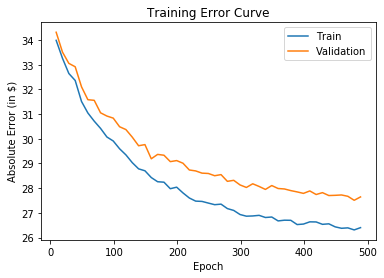

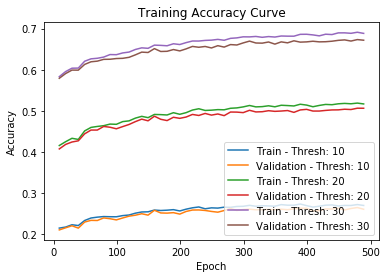

---[ITER 10] loss: 0.288035  time: 2.606
---[ITER 20] loss: 0.289397  time: 2.556
---[ITER 30] loss: 0.280519  time: 2.593
---[ITER 40] loss: 0.277981  time: 2.565
---[ITER 50] loss: 0.285721  time: 2.558
---[ITER 60] loss: 0.285815  time: 2.580
---[ITER 70] loss: 0.294348  time: 2.544
---[ITER 80] loss: 0.286943  time: 2.736
---[ITER 90] loss: 0.287891  time: 2.849
---[ITER 100] loss: 0.285888  time: 2.739
---[ITER 110] loss: 0.297527  time: 2.866
---[ITER 120] loss: 0.292620  time: 2.600
---[ITER 130] loss: 0.285414  time: 2.704
---[ITER 140] loss: 0.285080  time: 2.995
---[ITER 150] loss: 0.282625  time: 2.766
---[ITER 160] loss: 0.292929  time: 2.736
[EPOCH 491] loss: 0.287019  time: 45.087
---[ITER 10] loss: 0.296591  time: 3.236
---[ITER 20] loss: 0.292830  time: 3.476
---[ITER 30] loss: 0.291341  time: 4.054
---[ITER 40] loss: 0.275598  time: 2.823
---[ITER 50] loss: 0.282634  time: 2.711
---[ITER 60] loss: 0.282836  time: 2.756
---[ITER 70] loss: 0.276088  time: 2.784
---[ITER 

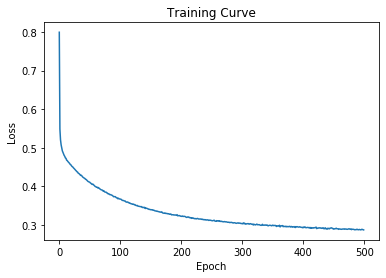

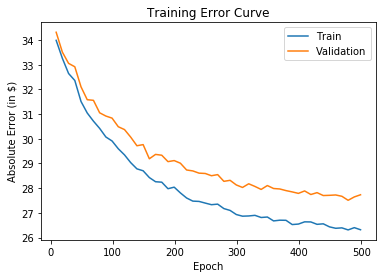

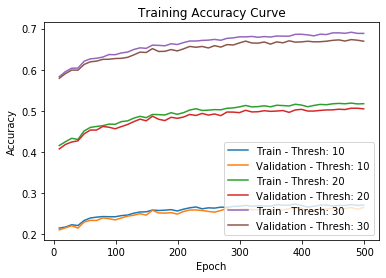

---[ITER 10] loss: 0.278114  time: 2.623
---[ITER 20] loss: 0.290279  time: 2.638
---[ITER 30] loss: 0.278866  time: 3.841
---[ITER 40] loss: 0.284542  time: 3.492
---[ITER 50] loss: 0.294874  time: 2.665
---[ITER 60] loss: 0.292000  time: 2.649
---[ITER 70] loss: 0.284551  time: 2.621
---[ITER 80] loss: 0.287791  time: 2.819
---[ITER 90] loss: 0.290284  time: 3.646
---[ITER 100] loss: 0.285978  time: 2.642
---[ITER 110] loss: 0.281811  time: 2.601
---[ITER 120] loss: 0.284924  time: 2.692
---[ITER 130] loss: 0.291561  time: 2.614
---[ITER 140] loss: 0.282495  time: 2.684
---[ITER 150] loss: 0.290300  time: 2.663
---[ITER 160] loss: 0.286517  time: 2.608
[EPOCH 501] loss: 0.287039  time: 47.573
---[ITER 10] loss: 0.287897  time: 2.645
---[ITER 20] loss: 0.297759  time: 2.657
---[ITER 30] loss: 0.279940  time: 2.645
---[ITER 40] loss: 0.286274  time: 2.656
---[ITER 50] loss: 0.296702  time: 2.640
---[ITER 60] loss: 0.285710  time: 2.672
---[ITER 70] loss: 0.288404  time: 2.674
---[ITER 

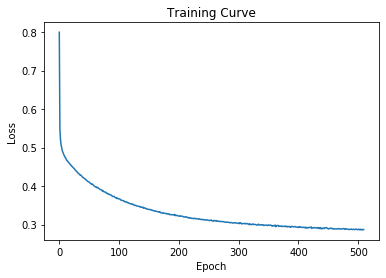

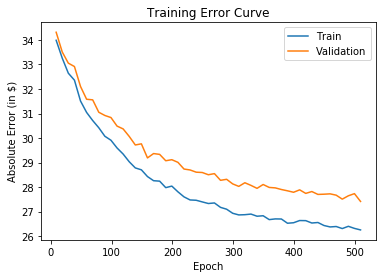

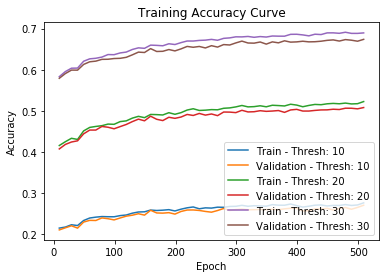

---[ITER 10] loss: 0.287437  time: 2.701
---[ITER 20] loss: 0.282200  time: 2.681
---[ITER 30] loss: 0.296091  time: 2.690
---[ITER 40] loss: 0.281540  time: 2.807
---[ITER 50] loss: 0.274903  time: 2.647
---[ITER 60] loss: 0.284573  time: 2.650
---[ITER 70] loss: 0.287503  time: 2.666
---[ITER 80] loss: 0.277443  time: 2.676
---[ITER 90] loss: 0.277347  time: 2.672
---[ITER 100] loss: 0.293020  time: 2.735
---[ITER 110] loss: 0.283593  time: 2.655
---[ITER 120] loss: 0.283922  time: 2.678
---[ITER 130] loss: 0.296532  time: 2.662
---[ITER 140] loss: 0.282191  time: 2.720
---[ITER 150] loss: 0.297694  time: 2.713
---[ITER 160] loss: 0.309575  time: 2.645
[EPOCH 511] loss: 0.286899  time: 45.217
---[ITER 10] loss: 0.289672  time: 2.649
---[ITER 20] loss: 0.279532  time: 2.774
---[ITER 30] loss: 0.285471  time: 2.666
---[ITER 40] loss: 0.285857  time: 2.667
---[ITER 50] loss: 0.294461  time: 2.642
---[ITER 60] loss: 0.283734  time: 3.194
---[ITER 70] loss: 0.293206  time: 2.716
---[ITER 

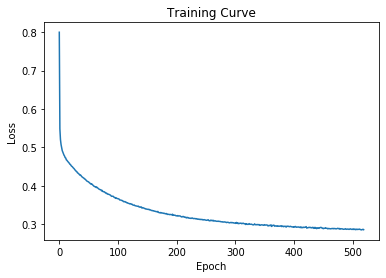

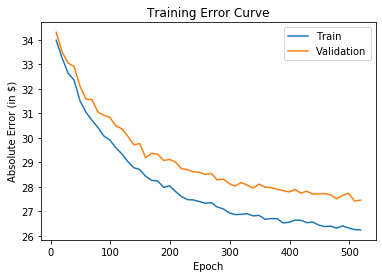

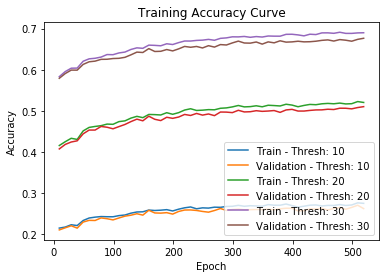

---[ITER 10] loss: 0.293316  time: 2.597
---[ITER 20] loss: 0.297659  time: 2.655
---[ITER 30] loss: 0.274270  time: 2.664
---[ITER 40] loss: 0.290694  time: 2.650
---[ITER 50] loss: 0.276589  time: 2.583
---[ITER 60] loss: 0.275205  time: 2.621
---[ITER 70] loss: 0.288393  time: 2.548
---[ITER 80] loss: 0.288216  time: 2.588
---[ITER 90] loss: 0.267004  time: 2.743
---[ITER 100] loss: 0.282371  time: 2.729
---[ITER 110] loss: 0.283008  time: 2.637
---[ITER 120] loss: 0.293042  time: 2.587
---[ITER 130] loss: 0.297510  time: 2.562
---[ITER 140] loss: 0.288160  time: 2.689
---[ITER 150] loss: 0.291781  time: 2.612
---[ITER 160] loss: 0.280017  time: 2.590
[EPOCH 521] loss: 0.285787  time: 44.054
---[ITER 10] loss: 0.295949  time: 2.591
---[ITER 20] loss: 0.285187  time: 2.644
---[ITER 30] loss: 0.270350  time: 2.613
---[ITER 40] loss: 0.279381  time: 2.541
---[ITER 50] loss: 0.279229  time: 2.554
---[ITER 60] loss: 0.286565  time: 2.594
---[ITER 70] loss: 0.290876  time: 2.675
---[ITER 

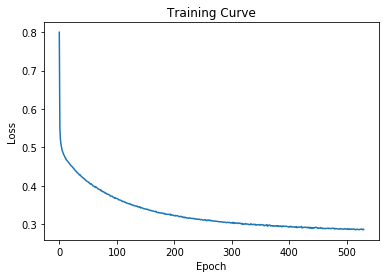

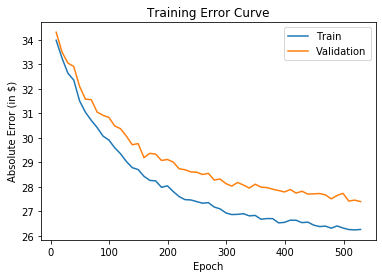

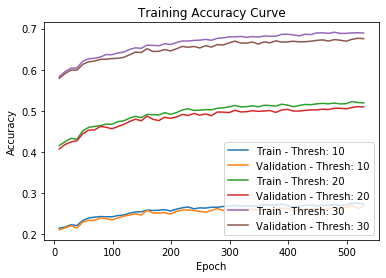

---[ITER 10] loss: 0.288446  time: 2.700
---[ITER 20] loss: 0.290135  time: 3.066
---[ITER 30] loss: 0.288927  time: 2.793
---[ITER 40] loss: 0.288060  time: 2.690
---[ITER 50] loss: 0.288841  time: 2.648
---[ITER 60] loss: 0.287946  time: 2.662
---[ITER 70] loss: 0.288891  time: 2.856
---[ITER 80] loss: 0.283970  time: 2.745
---[ITER 90] loss: 0.297710  time: 2.661
---[ITER 100] loss: 0.282014  time: 2.712
---[ITER 110] loss: 0.284042  time: 3.134
---[ITER 120] loss: 0.290367  time: 3.107
---[ITER 130] loss: 0.291989  time: 2.712
---[ITER 140] loss: 0.280490  time: 2.700
---[ITER 150] loss: 0.284737  time: 2.739
---[ITER 160] loss: 0.281498  time: 2.657
[EPOCH 531] loss: 0.286911  time: 46.633
---[ITER 10] loss: 0.285247  time: 2.661
---[ITER 20] loss: 0.279337  time: 2.665
---[ITER 30] loss: 0.283025  time: 2.644
---[ITER 40] loss: 0.286946  time: 2.628
---[ITER 50] loss: 0.289300  time: 2.720
---[ITER 60] loss: 0.283175  time: 2.683
---[ITER 70] loss: 0.291401  time: 2.668
---[ITER 

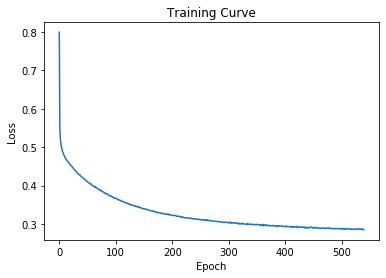

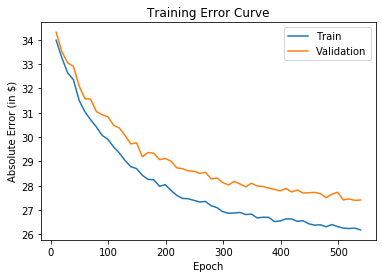

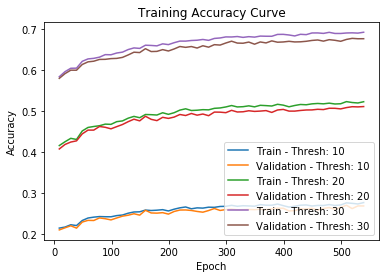

---[ITER 10] loss: 0.277857  time: 2.705
---[ITER 20] loss: 0.281385  time: 2.753
---[ITER 30] loss: 0.297004  time: 2.667
---[ITER 40] loss: 0.286584  time: 2.733
---[ITER 50] loss: 0.292282  time: 2.685
---[ITER 60] loss: 0.291754  time: 2.567
---[ITER 70] loss: 0.287595  time: 2.647
---[ITER 80] loss: 0.289768  time: 2.726
---[ITER 90] loss: 0.272859  time: 2.547
---[ITER 100] loss: 0.277040  time: 2.576
---[ITER 110] loss: 0.275484  time: 2.585
---[ITER 120] loss: 0.284688  time: 2.577
---[ITER 130] loss: 0.294092  time: 2.589
---[ITER 140] loss: 0.281955  time: 2.584
---[ITER 150] loss: 0.291187  time: 2.532
---[ITER 160] loss: 0.277962  time: 2.537
[EPOCH 541] loss: 0.284862  time: 43.992
---[ITER 10] loss: 0.293953  time: 2.524
---[ITER 20] loss: 0.278384  time: 2.556
---[ITER 30] loss: 0.285761  time: 2.549
---[ITER 40] loss: 0.274853  time: 2.596
---[ITER 50] loss: 0.287511  time: 2.577
---[ITER 60] loss: 0.295598  time: 2.562
---[ITER 70] loss: 0.276178  time: 2.558
---[ITER 

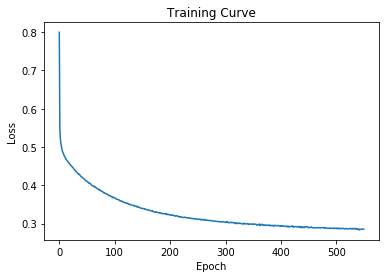

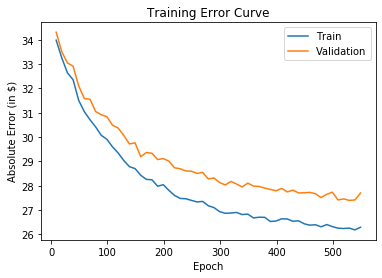

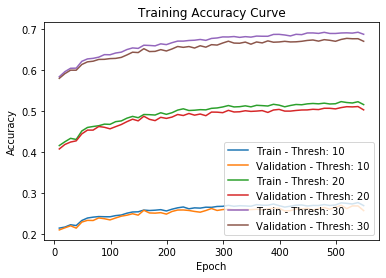

---[ITER 10] loss: 0.278858  time: 2.635
---[ITER 20] loss: 0.285293  time: 2.554
---[ITER 30] loss: 0.263889  time: 2.550
---[ITER 40] loss: 0.284427  time: 2.530
---[ITER 50] loss: 0.285092  time: 2.511
---[ITER 60] loss: 0.284961  time: 2.522
---[ITER 70] loss: 0.295033  time: 2.533
---[ITER 80] loss: 0.279044  time: 2.528
---[ITER 90] loss: 0.275988  time: 2.520
---[ITER 100] loss: 0.286158  time: 2.589
---[ITER 110] loss: 0.289055  time: 2.542
---[ITER 120] loss: 0.288749  time: 2.917
---[ITER 130] loss: 0.285097  time: 2.557
---[ITER 140] loss: 0.280301  time: 2.551
---[ITER 150] loss: 0.280030  time: 2.587
---[ITER 160] loss: 0.285851  time: 2.544
[EPOCH 551] loss: 0.283467  time: 43.115
---[ITER 10] loss: 0.274195  time: 2.542
---[ITER 20] loss: 0.291186  time: 2.518
---[ITER 30] loss: 0.289706  time: 2.504
---[ITER 40] loss: 0.285018  time: 2.740
---[ITER 50] loss: 0.282814  time: 2.617
---[ITER 60] loss: 0.299376  time: 3.023
---[ITER 70] loss: 0.285722  time: 2.712
---[ITER 

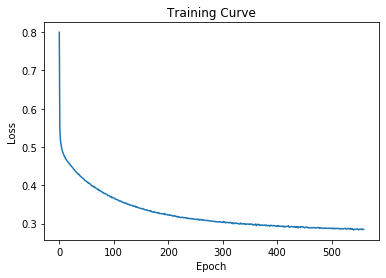

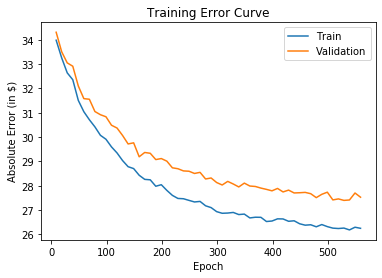

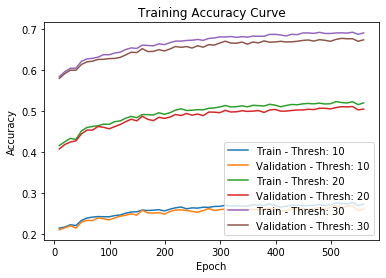

---[ITER 10] loss: 0.279562  time: 2.725
---[ITER 20] loss: 0.279313  time: 2.643
---[ITER 30] loss: 0.282946  time: 2.743
---[ITER 40] loss: 0.288206  time: 3.906
---[ITER 50] loss: 0.284020  time: 3.688
---[ITER 60] loss: 0.280283  time: 3.934
---[ITER 70] loss: 0.282430  time: 2.667
---[ITER 80] loss: 0.277647  time: 2.843
---[ITER 90] loss: 0.282845  time: 2.707
---[ITER 100] loss: 0.284983  time: 2.703
---[ITER 110] loss: 0.297749  time: 2.621
---[ITER 120] loss: 0.272897  time: 2.579
---[ITER 130] loss: 0.291344  time: 2.615
---[ITER 140] loss: 0.295843  time: 2.673
---[ITER 150] loss: 0.275525  time: 2.571
---[ITER 160] loss: 0.285939  time: 2.573
[EPOCH 561] loss: 0.283695  time: 48.204
---[ITER 10] loss: 0.279325  time: 2.587
---[ITER 20] loss: 0.289614  time: 2.562
---[ITER 30] loss: 0.280202  time: 2.642
---[ITER 40] loss: 0.284676  time: 2.740
---[ITER 50] loss: 0.295951  time: 2.885
---[ITER 60] loss: 0.286120  time: 2.622
---[ITER 70] loss: 0.289762  time: 2.605
---[ITER 

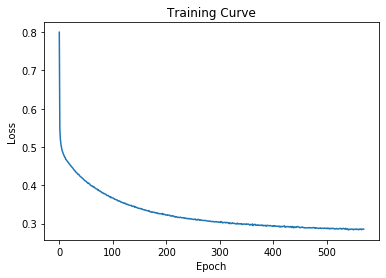

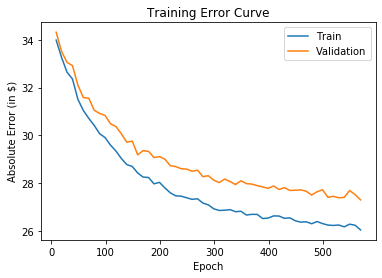

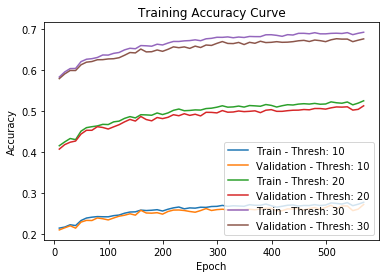

---[ITER 10] loss: 0.278767  time: 2.609
---[ITER 20] loss: 0.284522  time: 2.715
---[ITER 30] loss: 0.284052  time: 2.599
---[ITER 40] loss: 0.291894  time: 2.641
---[ITER 50] loss: 0.278769  time: 2.610
---[ITER 60] loss: 0.276947  time: 2.667
---[ITER 70] loss: 0.284563  time: 2.666
---[ITER 80] loss: 0.287696  time: 2.650
---[ITER 90] loss: 0.283978  time: 2.653
---[ITER 100] loss: 0.298526  time: 2.645
---[ITER 110] loss: 0.271395  time: 2.561
---[ITER 120] loss: 0.286718  time: 2.572
---[ITER 130] loss: 0.279758  time: 2.617
---[ITER 140] loss: 0.278540  time: 2.652
---[ITER 150] loss: 0.283154  time: 2.634
---[ITER 160] loss: 0.282907  time: 2.636
[EPOCH 571] loss: 0.283590  time: 44.249
---[ITER 10] loss: 0.290027  time: 2.627
---[ITER 20] loss: 0.284773  time: 2.649
---[ITER 30] loss: 0.297663  time: 2.612
---[ITER 40] loss: 0.279491  time: 2.603
---[ITER 50] loss: 0.281808  time: 2.736
---[ITER 60] loss: 0.272642  time: 2.795
---[ITER 70] loss: 0.278729  time: 2.582
---[ITER 

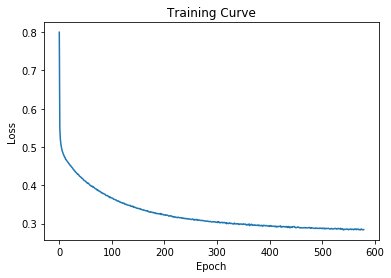

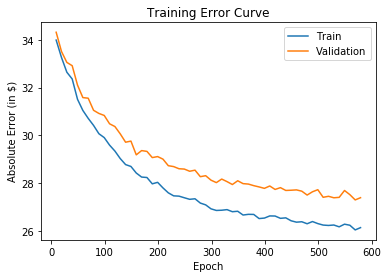

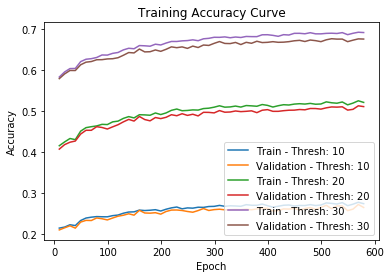

---[ITER 10] loss: 0.301894  time: 2.593
---[ITER 20] loss: 0.279469  time: 2.644
---[ITER 30] loss: 0.281069  time: 2.630
---[ITER 40] loss: 0.279480  time: 2.557
---[ITER 50] loss: 0.286005  time: 2.635
---[ITER 60] loss: 0.273158  time: 2.621
---[ITER 70] loss: 0.279989  time: 2.568
---[ITER 80] loss: 0.273417  time: 2.578
---[ITER 90] loss: 0.270212  time: 2.593
---[ITER 100] loss: 0.289400  time: 2.579
---[ITER 110] loss: 0.290831  time: 2.578
---[ITER 120] loss: 0.286888  time: 2.594
---[ITER 130] loss: 0.276752  time: 2.580
---[ITER 140] loss: 0.288473  time: 2.720
---[ITER 150] loss: 0.288309  time: 2.613
---[ITER 160] loss: 0.283694  time: 2.601
[EPOCH 581] loss: 0.283546  time: 43.756
---[ITER 10] loss: 0.284739  time: 2.759
---[ITER 20] loss: 0.278318  time: 2.609
---[ITER 30] loss: 0.288896  time: 2.576
---[ITER 40] loss: 0.283048  time: 2.732
---[ITER 50] loss: 0.281404  time: 2.610
---[ITER 60] loss: 0.277639  time: 2.559
---[ITER 70] loss: 0.287970  time: 2.591
---[ITER 

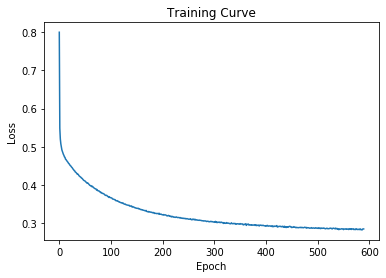

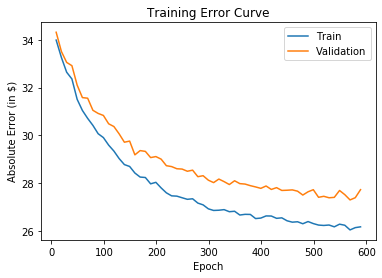

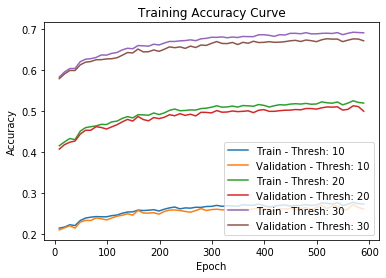

---[ITER 10] loss: 0.285285  time: 2.707
---[ITER 20] loss: 0.277635  time: 3.062
---[ITER 30] loss: 0.284319  time: 2.823
---[ITER 40] loss: 0.278408  time: 2.900
---[ITER 50] loss: 0.279909  time: 2.809
---[ITER 60] loss: 0.281074  time: 3.001
---[ITER 70] loss: 0.283555  time: 2.810
---[ITER 80] loss: 0.283738  time: 2.789
---[ITER 90] loss: 0.275992  time: 2.847
---[ITER 100] loss: 0.289117  time: 2.735
---[ITER 110] loss: 0.287421  time: 2.655
---[ITER 120] loss: 0.283018  time: 3.325
---[ITER 130] loss: 0.286757  time: 2.780
---[ITER 140] loss: 0.275655  time: 2.910
---[ITER 150] loss: 0.296669  time: 3.585
---[ITER 160] loss: 0.284361  time: 2.889
[EPOCH 591] loss: 0.283828  time: 48.999
---[ITER 10] loss: 0.281969  time: 3.199
---[ITER 20] loss: 0.294956  time: 2.858
---[ITER 30] loss: 0.280291  time: 2.811
---[ITER 40] loss: 0.281681  time: 3.766
---[ITER 50] loss: 0.287447  time: 3.241
---[ITER 60] loss: 0.270795  time: 3.262
---[ITER 70] loss: 0.285181  time: 3.177
---[ITER 

In [ ]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)

In [36]:
checkpoint = torch.load("../test/Brian/nov17_test02/final/checkpoint_final.tar")

In [40]:
print(min(checkpoint["val_error"]))
print(checkpoint["val_error"].index(min(checkpoint["val_error"])))

28.53676733121243
96


In [32]:
print(max(checkpoint["train_acc"][1]))
print(checkpoint["train_acc"][1].index(max(checkpoint["train_acc"][1])))

0.20375450230183909
0.39816449204493953
0.5659423228299502
